```ml_model_and_plot.ipynb```
#    <font color='red'>Performance-Aware Energy-Efficient GPU Frequency Selection using DNN-based Models</font>
#### _Date_:    ***20230625*** <br>
###  _Authors_: Ghazanfar ALI *and* Mert SIDE <br>

> ***for the paper titled:*** Performance-Aware Energy-Efficient GPU Frequency Selection using DNN-based Models <br>
> ***venue:*** 52nd International Conference on Parallel Processing (ICPP) 2023

<hr style="border:2px solid gray">


***README***

First three code cells are used to include the needed libraries, sets global variables, and define shared functions. Please run them before running anything else


___
### IMPORT LIBRARIES AND SET GLOBAL VARIABLES

In [1]:
#!/usr/bin/python3

# IMPORT LIBRARIES AND SET GLOBAL VARIABLES ----------------------------------

# GENERIC
import sys
import statistics
import itertools
import datetime as dt
from os import error
from typing_extensions import runtime

# NUMPY
import numpy as np
from numpy.lib import type_check
from numpy.core.fromnumeric import mean

# PANDAS
import pandas as pd

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import Normalize
from matplotlib.offsetbox import (TextArea, 
                                  DrawingArea, 
                                  OffsetImage, 
                                  AnnotationBbox)
from matplotlib.patches import Rectangle

# SEABORN
import seaborn as sns
from seaborn.palettes import color_palette

# SKLEARN
import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.utils import shuffle

# MISC.
# from xgboost import XGBRegressor

xss = 6
ss  = 7   # 8
ms  = 8   # 10
ls  = 9   # 12
xls = 14 # default 14
xxls = 16

matplotlib.rc('xtick', labelsize=ss) 
matplotlib.rc('ytick', labelsize=ss) 

figureExtension = '.pdf'
# figureExtension = '.png'
# figureExtension = '.svg'
preferredDPI = 400
# ============================================================================

___
### Set global color, hatch and marker standards

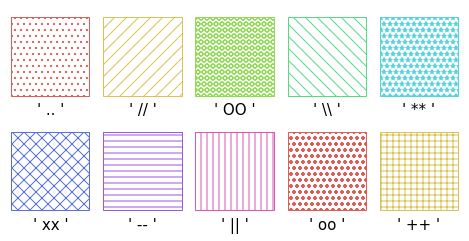

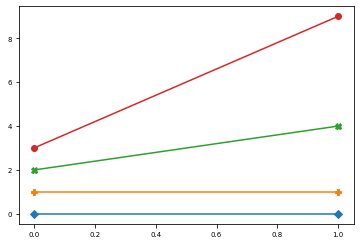

In [2]:
# DEMO hatches ===============================================================
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(6.4, 3.2),
                        facecolor='white')

# SWATCHES -------------------------------------------------------------------
# baseColors  = sns.color_palette("Paired")
baseColors  = sns.color_palette("hls", 8)

baseHatches = ['..', '//', 'OO', '\\\\', '**', 'xx', '--', '||', 'oo', '++'] # ['oo', 'xx', '++', '//', '\\\\', '--', '||', '..', '**', 'OO']
baseMarkers = ['D', 'P', 'X', 'o'] # ['o', 'X', 'P', 'D']
alternateColors = ['r', 'g', 'b', 'm', 'y', 'c']
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

markerSize = 50

baseLineColor = 'deeppink'
baseLinewidth = 2
baseArrowColor = 'tomato'
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
# https://matplotlib.org/stable/api/markers_api.html

# colors = itertools.cycle(['r','g', 'b', 'm', 'y', 'c'])
# MARKERS ['o', '+', '*', '.', 'x', '_', '|', 's', 'd', '^', 'v', 
#          '>', '<', 'p', 'h', 'X', '8', '1', '2',',','P']

colors=itertools.cycle(baseColors)
hatches=itertools.cycle(baseHatches)
markers=itertools.cycle(baseMarkers)

def hatches_plot(ax, h):
    ax.add_patch(Rectangle((0, 0), 2, 2, fill=False, hatch=h, color=next(colors)))
    ax.text(1, -0.5, f"' {h} '", size=15, ha='center')
    ax.axis('equal')
    ax.axis('off')

for ax, h in zip(axs.flat, hatches):
    hatches_plot(ax, h)
   
plt.show()

plt.close()

i = 0
for m in baseMarkers:
    plt.plot([i, i*i], marker=next(markers))
    i = i + 1
# END OF DEMO hatches ========================================================

___
### Global Estimation Functions

In [3]:
# ============================================================================
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# ============================================================================
def EDP_Optimal(df,ecol,tcol):
    wt = 0.5
    we = 0.5

    df['score'] =  (wt*df[tcol]) * (we*df[ecol])

    optimum_sol = df.loc[df['score'] == min(df['score'])]
    f = int(optimum_sol.iloc[0]['sm_app_clock'])
    x = round(optimum_sol.iloc[0][tcol],2)
    y = round(optimum_sol.iloc[0]['power_usage'],2)
    z = round(optimum_sol.iloc[0][ecol],2)
    return f,x,y,z

# ============================================================================
def ED2P_Optimal(df,ecol,tcol):
    wt = 0.5
    we = 0.5

    df['score'] =  (wt*(df[tcol]**2)) * (we*df[ecol])

    optimum_sol = df.loc[df['score'] == min(df['score'])]
    f = int(optimum_sol.iloc[0]['sm_app_clock'])
    x = round(optimum_sol.iloc[0][tcol],2)
    y = round(optimum_sol.iloc[0]['power_usage'],2)
    z = round(optimum_sol.iloc[0][ecol],2)
    return f,x,y,z

# ============================================================================

___
___
___

# Figure 1: Power consumption, execution time, energy consumption, and FLOPS variations across different frequency configurations for DGEMM (upper) and STREAM (lower) on NVIDIA A100 Ampere GPU.

In [ ]:
# ============================================================================
def dgemm_stream_perf_pwr_dvfs(dgemm_dcgm,dgemm_perf,stream_dcgm,stream_perf):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize * 3
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    #Create combo chart figsize=(6,10)
    fig, axs = plt.subplots(2, 4,figsize=(20,5))
    plt.style.use('classic')
    sns.set_context("paper", font_scale=1)

    # a ======================================================================
    color = next(colors) # 'tab:blue'
    g3 = sns.scatterplot(ax=axs[0][0], data=dgemm_dcgm, 
                         x=dgemm_dcgm['sm_app_clock'], y=dgemm_dcgm['power_usage'], 
                         color=color,s=marker_size,marker=next(markers))
    axs[0][0].set_xlabel( '(a) DGEMM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[0][0].set_ylabel('Power (W)', weight='bold',fontsize=xxls)
    axs[0][0].tick_params(axis='both', labelsize=xls, length=10)
    axs[0][0].set_xlim([475, 1430])
    axs[0][0].set_ylim([0, 600])
    axs[0][0].set_yticks(np.arange(0, 510, 100))
    axs[0][0].axhline(y=500,linestyle='dashed',color=baseLineColor,
                      linewidth=baseLinewidth*2,zorder=0,label='TDP')
    axs[0][0].legend(loc='lower right', prop={'size': xxls})
    axs[0][0].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')
    
    # b ======================================================================
    color = next(colors) # 'tab:red'
    g2 = sns.scatterplot(ax=axs[0][1], data=dgemm_perf, 
                         x=dgemm_perf['dvfs'], y=dgemm_perf['kernel_runtime'].div(1000), 
                         color=color,s=marker_size,marker=next(markers))
    axs[0][1].set_xlabel( '(b) DGEMM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[0][1].set_ylabel('Exec. Time (s)', weight='bold',fontsize=xxls)
    axs[0][1].tick_params(axis='both', labelsize=xls, length=10)
    axs[0][1].set_xlim([475, 1430])
    # axs[0][1].set_yticks(np.arange(3, 12, 2))
    min_time  = dgemm_perf['kernel_runtime'].min()
    freq = dgemm_perf.loc[dgemm_perf['kernel_runtime'] == dgemm_perf['kernel_runtime'].min()]['dvfs'].values[0]    
    min_time = min_time/1000
    offsetbox = TextArea(str(round(min_time, 1))+' s, '+str(freq)+' MHz', textprops={'fontsize':xls})
    print (freq,min_time)
    xy = (freq, min_time)
    ab = AnnotationBbox(offsetbox, xy,
                xybox=(-75.,75),
                xycoords='data',
                fontsize=xxls,
                boxcoords='offset points',
                arrowprops=dict(arrowstyle='-|>',color=baseArrowColor,linewidth=baseLinewidth,
                                connectionstyle="angle,angleA=0,angleB=90,rad=6"))
    axs[0][1].add_artist(ab)
    axs[0][1].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')
    
    # c ======================================================================
    color = next(colors) # 'purple'
    # dgemm_perf['flops/watt'] = dgemm_perf['flops']/dgemm_dcgm['power_usage']
    # print (dgemm_perf['flops/watt'])
    dgemm_dcgm['energy'] = dgemm_dcgm['power_usage'].mul(dgemm_dcgm['run_time'])
    g4 = sns.scatterplot(ax=axs[0][2], data=dgemm_dcgm, 
                         x=dgemm_dcgm['sm_app_clock'], y=dgemm_dcgm['energy'], 
                         color=color,s=marker_size,marker=next(markers))
    axs[0][2].set_xlabel( '(c) DGEMM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[0][2].set_ylabel('Energy (J)', weight='bold',fontsize=xxls)
    axs[0][2].tick_params(axis='both', labelsize=xls, length=10)
    axs[0][2].set_xlim([475, 1430])
    # axs[0][2].set_yticks(np.arange(800, 980, 40))
    # start
    min_energy  = dgemm_dcgm['energy'].min()
    freq = dgemm_dcgm.loc[dgemm_dcgm['energy'] == min_energy]['sm_app_clock'].values[0]    
    offsetbox = TextArea(str(round(min_energy, 1))+' J, '+str(freq)+' MHz', textprops={'fontsize':xls})
    xy = (freq, min_energy)
    ab = AnnotationBbox(offsetbox, xy,
                xybox=(-35,75),
                xycoords='data',
                fontsize=xxls,
                boxcoords='offset points',
                arrowprops=dict(arrowstyle='-|>',color=baseArrowColor,linewidth=baseLinewidth,
                                connectionstyle="angle,angleA=0,angleB=90,rad=6"))
    axs[0][2].add_artist(ab)
    axs[0][2].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')
    # stop
    
    # d ======================================================================
    color = next(colors) # 'tab:green'
    g1 = sns.scatterplot(ax=axs[0][3], data=dgemm_perf, 
                         x=dgemm_perf['dvfs'], y=dgemm_perf['flops'].div(1000), 
                         color=color, palette='summer',s=marker_size,marker=next(markers))
    axs[0][3].set_xlabel( '(d) DGEMM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[0][3].set_ylabel( 'FLOPS (T)',weight='bold',fontsize=xxls)
    axs[0][3].tick_params(axis='both', labelsize=xls, length=10)
    axs[0][3].set_xlim([475, 1430])
    axs[0][3].set_ylim([0, 22])
    # axs[0][3].set_yticks(np.arange(0, 8.5, 2))
    axs[0][3].axhline(y=19.5,linestyle='dashed',color=baseLineColor,
                      linewidth=baseLinewidth*2,zorder=0,label='Max. Attainable')
    axs[0][3].legend(loc='lower right', prop={'size': xxls})
    axs[0][3].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')

    # e ======================================================================
    color = next(colors) # 'tab:blue'
    g3 = sns.scatterplot(ax=axs[1][0], data=stream_dcgm, 
                         x=stream_dcgm['sm_app_clock'], y=stream_dcgm['power_usage'], 
                         color=color,s=marker_size,marker=next(markers))
    axs[1][0].set_xlabel( '(e) STREAM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[1][0].set_ylabel('Power (W)', weight='bold',fontsize=xxls)
    axs[1][0].tick_params(axis='both', labelsize=xls, length=10)
    axs[1][0].axhline(y=500,linestyle='dashed',color=baseLineColor,
                      linewidth=baseLinewidth*2,zorder=0,label='TDP')
    axs[1][0].set_xlim([475, 1430])
    axs[1][0].set_ylim([0, 600])
    axs[1][0].set_yticks(np.arange(0, 510, 100))
    axs[1][0].legend(loc='center left', prop={'size': xxls})
    axs[1][0].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')

    # f ======================================================================
    color = next(colors) # 'tab:red'
    g2 = sns.scatterplot(ax=axs[1][1], data=stream_perf, 
                         x=stream_perf['dvfs'], y=stream_perf['kernel_runtime'], 
                         color=color,s=marker_size,marker=next(markers))
    axs[1][1].set_xlabel( '(f) STREAM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[1][1].set_ylabel('Exec. Time (s)', weight='bold',fontsize=xxls)
    axs[1][1].tick_params(axis='both', labelsize=xls, length=10)
    axs[1][1].set_xlim([475, 1430])
    axs[1][1].set_yticks(np.arange(2.2, 4.3, 0.4))
    # start
    min_time  = stream_perf['kernel_runtime'].min()
    freq = stream_perf.loc[stream_perf['kernel_runtime'] == min_time]['dvfs'].values[0]    
    offsetbox = TextArea(str(round(min_time, 1))+' s, '+str(freq)+' MHz', textprops={'fontsize':xls})
    xy = (freq, min_time)
    ab = AnnotationBbox(offsetbox, xy,
                xybox=(-30,75),
                xycoords='data',
                fontsize=xxls,
                boxcoords='offset points',
                arrowprops=dict(arrowstyle='-|>',color=baseArrowColor,linewidth=baseLinewidth,
                                connectionstyle="angle,angleA=0,angleB=90,rad=6"))
    axs[1][1].add_artist(ab)
    axs[1][1].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')

    # g ======================================================================
    color = next(colors) # 'purple'
    # stream_perf['bw/watt'] = stream_perf['bandwidth']/stream_dcgm['power_usage']
    # print (stream_perf['bw/watt'])
    stream_dcgm['energy'] = stream_dcgm['power_usage'].mul(stream_dcgm['run_time'])
    g4 = sns.scatterplot(ax=axs[1][2], data=stream_dcgm, 
                         x=stream_dcgm['sm_app_clock'], y=stream_dcgm['energy'], 
                         color=color,s=marker_size,marker=next(markers))
    axs[1][2].set_xlabel( '(g) STREAM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[1][2].set_ylabel('Energy (J)', weight='bold',fontsize=xxls)
    axs[1][2].tick_params(axis='both', labelsize=xls, length=10)
    axs[1][2].set_xlim([475, 1430])
    axs[1][2].set_yticks(np.arange(350, 660, 50))
    # start
    min_energy  = stream_dcgm['energy'].min()
    freq = stream_dcgm.loc[stream_dcgm['energy'] == min_energy]['sm_app_clock'].values[0]    
    offsetbox = TextArea(str(round(min_energy, 1))+' J, '+str(freq)+' MHz', textprops={'fontsize':xls})
    xy = (freq, min_energy)
    ab = AnnotationBbox(offsetbox, xy,
                xybox=(0,50),
                xycoords='data',
                fontsize=xxls,
                boxcoords='offset points',
                arrowprops=dict(arrowstyle='-|>',color=baseArrowColor,linewidth=baseLinewidth,
                                connectionstyle="angle,angleA=0,angleB=90,rad=6"))
    axs[1][2].add_artist(ab)
    axs[1][2].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')
    # stop

    # h ======================================================================
    color = next(colors) # 'tab:green'
    g1 = sns.scatterplot(ax=axs[1][3], data=stream_perf, 
                         x=stream_perf['dvfs'], y=stream_perf['bandwidth'], 
                         color=color, palette='summer',s=marker_size,marker=next(markers))
    axs[1][3].set_xlabel( '(h) STREAM-Core Frequency (MHz)',weight='bold',fontsize=xxls)
    axs[1][3].set_ylabel( 'Bandwidth (GB/s)',weight='bold',fontsize=xxls)
    axs[1][3].tick_params(axis='both', labelsize=xls, length=10)    
    axs[1][3].set_xlim([475, 1430])
    axs[1][3].set_ylim([1000, 2200])
    axs[1][3].axhline(y=2039,linestyle='dashed',color=baseLineColor,
                      linewidth=baseLinewidth*2,zorder=0,label='Max. Attainable')
    axs[1][3].legend(loc='lower right', prop={'size': xxls})
    axs[1][3].tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                          reset=True, color = 'black')
    # ...................................................................
    
    fig.subplots_adjust( wspace=0.1)
    fig.tight_layout()
    # fig.autofmt_xdate()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        
    for i in range(2):
        for j in range(4):
            axs[i][j].grid(False)

    plt.savefig('figures/tflops_bw_runtime_pwr_dvfs/GA100_tflops_bw_runtime_pwr_dvfs' 
                + figureExtension, transparent=True, bbox_inches = 'tight', 
                pad_inches = 0.1, dpi=400)
    plt.close()

# ============================================================================    

dgemm_dcgm = pd.read_csv('datasets/dgemm_stream/GA100-dvfs-dgemm-dcgm.csv')
stream_dcgm = pd.read_csv('datasets/dgemm_stream/GA100-dvfs-stream-dcgm.csv')

dg = pd.read_csv('datasets/dgemm_stream/GA100-dvfs-dgemm-perf.csv')
dgemm_perf = dg.loc[dg['dvfs'] >= 510]

ds = pd.read_csv('datasets/dgemm_stream/GA100-dvfs-stream-perf.csv')
stream_perf = ds.loc[ds['dvfs'] >= 510]

dgemm_stream_perf_pwr_dvfs(dgemm_dcgm,dgemm_perf,stream_dcgm,stream_perf)
# ============================================================================

___
___
___

# Figure 2: Prediction accuracy for power consumption across different DVFS configurations for LAMMPS, NAMD, and LSTM using RFR, XGBR, SVR, and MLR algorithms on NVIDIA V100 Volta GPU.

In [62]:
# figureExtension = '.png'
# ============================================================================

f = 'datasets/v100_pwr_all_algs_4f.csv'
df = pd.read_csv(f)
print (df)

# ============================================================================

ax = plt.figure(figsize=(6, 2)).add_subplot(111)
plt.style.use('classic')
sns.set_context("paper",font_scale=1)    
sns.set_style("whitegrid")

graph = sns.barplot(x="Algorithm",y='Accuracy',hue='App',data=df, 
                    palette='Pastel1', facecolor='none', edgecolor='black', 
                    color='black')

    #   ...   ...   ...   ...   ...   ...   ...   ...
num_locations = len(df['Algorithm'].unique()) 

# SWATCHES -------------------------------------------------------------------
colors  = itertools.cycle(baseColors)
hatches = itertools.cycle(baseHatches)
markers = itertools.cycle(baseMarkers)
marker_size = markerSize * 3
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

for i, bar in enumerate(ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
        color = next(colors)
    print(str(type(bar)))
    bar.set_hatch(hatch)
    bar.set_edgecolor(color)

change_width(ax, .15)
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", 
          borderaxespad=0, ncol=4, fontsize=ls, edgecolor='black')
    
for p in graph.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 8), 
                textcoords = 'offset points', size=ls, fontweight='bold')

ax.set_xlabel("Machine Learning Algorithm",weight='bold',fontsize=xls)
ax.set_ylabel('Accuracy (%)',weight='bold',fontsize=xls)
ax.set_ylim([-125, 150])

for spine in ax.spines.values():
    spine.set_edgecolor('black')
plt.tick_params(axis='both', which='major', labelsize=ls, direction = "in", 
                reset=True, color = 'black')
plt.grid(False)
# plt.grid(axis='x')
# plt.grid(axis='y')
graph.axhline(0, color='black')

# plt.xticks(fontsize=ms,rotation=30)
plt.tight_layout()

# ============================================================================

# plt.show()
plt.savefig('figures/multilearner_accuracy_v8' + figureExtension, transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400) 

plt.close()

# ============================================================================

        App  Accuracy Algorithm
0    LAMMPS      72.3       RFR
1    LAMMPS      71.4       SVR
2    LAMMPS      95.0      XGBR
3    LAMMPS      93.0       MLR
4      NAMD      87.2       RFR
5      NAMD      74.7       SVR
6      NAMD      91.6      XGBR
7      NAMD      95.9       MLR
8      LSTM      44.2       RFR
9      LSTM    -104.6       SVR
10     LSTM      80.7      XGBR
11     LSTM     -14.4       MLR
12  GROMACS      -2.4       RFR
13  GROMACS      87.2       SVR
14  GROMACS      30.6      XGBR
15  GROMACS      77.4       MLR
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.

# Power, performance and frequncy behaviors of DGEMM and STREAM on AMD Instinct MI210

In [5]:
# ============================================================================
# figureExtension = '.pdf'
def mi210_perf_prediction(dataFrame, app,ylbl):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    xAxis = 'Configured Frequency (MHz)'
    ax = plt.figure(figsize=(3, 1.75)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # df = dataFrame.sort_values('Activity')
    df = dataFrame
    graph = sns.barplot(x=xAxis, y=ylbl, hue='Feature', 
                        data=df, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
    if ylbl == 'Power (W)':
        graph.axhline(y=300, label='TDP',lw=1.5, color='tab:pink',ls='--')
    
    num_locations = len(df[xAxis].unique()) 
    
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)

    change_width(ax, .35)

    # '''
    h, l = graph.get_legend_handles_labels()
    labels = ['DGEMM','STREAM']
    if ylbl == 'Power (W)':
        labels = ['TDP','DGEMM','STREAM']
    graph.legend(h, labels, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', 
                 mode='expand', borderaxespad=0, ncol=3, fontsize=ls-3, edgecolor='black')
    # '''
    for p in graph.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 4), 
                    textcoords = 'offset points', size=ls, fontweight='bold')
    
    graph.set(xlabel=None)
    ax.set_xlabel(xAxis,weight='bold',fontsize=ls-2)
    ax.set_ylabel(ylbl,weight='bold',fontsize=ls-2)
    if ylbl == 'Measured Frequency (MHz)':
        ax.set_ylim([0, 2250])
    if ylbl == 'Time (Normalized)':
        ax.set_ylim([0, 1.2])
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    plt.xticks(fontsize=ms)
    plt.tick_params(axis='both', which='major', labelsize=ms, 
                    direction = 'in', reset=True, color = 'black')

    plt.grid(False)
    # plt.legend([],[],frameon=False)
    plt.tight_layout()
 
    plt.savefig('figures/tflops_bw_runtime_pwr_dvfs/mi210_'+ ylbl + "_v7" + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

# ============================================================================

apps = ['DGEMM','STREAM']
# plotype = 'n_run_time'
# plotype = 'power_usage'
plotype = 'sm_app_clock'
scorel = []
freql = []
featurel = []
for app in apps:
    f = 'datasets/mi210/mi210-ml-energy-rt-pwr-'+app+'.csv'
    df = pd.read_csv(f)
    print (df)
    # break

    for f in df['dvfs_level'].tolist():
        if f == 0:
            freql.append(500)
        elif f == 1:
            freql.append(800)
        elif f == 2:
            freql.append(1700)    
        scorel.append(round(df[df['dvfs_level']==f][plotype].values[0],1))
        featurel.append(app)
        # freql.append(round(f))
        # scorel.append(df[df['sm_app_clock']==f]['predicted_n_run_time'].values[0])
        # featurel.append('Predicted')
if plotype == 'n_run_time':
    ylbl = 'Time (Normalized)'
    d = {ylbl:scorel,'Feature':featurel,'Configured Frequency (MHz)':freql}
elif plotype == 'power_usage':
    ylbl = 'Power (W)'
    d = {ylbl:scorel,'Feature':featurel,'Configured Frequency (MHz)':freql}
elif plotype == 'sm_app_clock':
    ylbl = 'Measured Frequency (MHz)'
    d = {ylbl:scorel,'Feature':featurel,'Configured Frequency (MHz)':freql}
        
df = pd.DataFrame(data=d)
mi210_perf_prediction(df,app,ylbl)
# print (df)
# ============================================================================

   level_0  index  dvfs_level   VALUBusy  SALUBusy  MemUnitBusy  sm_app_clock  \
0        0      0           0  12.907620  3.745432    48.031512    500.000000   
1        1      1           1  12.596926  3.735418    49.047378   1301.993007   
2        2      2           2  12.601469  3.736648    49.040781   1305.314685   

   power_usage  dram_active  fp_active  n_power_usage  n_sm_app_clock  \
0   158.298611     0.490408   0.163381       0.524958        0.383049   
1   301.545455     0.490408   0.163381       1.000000        0.997455   
2   297.293706     0.490408   0.163381       0.985900        1.000000   

   predicted_n_power_usage  predicted_power_usage  run_time  n_run_time  \
0                 0.550059              165.86784      95.2    1.000000   
1                 1.013370              305.57727      43.3    0.454832   
2                 1.015906              306.34192      43.0    0.451681   

   predicted_n_run_time        energy    n_energy  predicted_n_energy  
0        

# Portability evaluation of performance model on AMD Instinct MI210

In [22]:
# ============================================================================
# figureExtension = '.pdf'
def mi210_perf_prediction(dataFrame, app,set_ylbl=0):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    xAxis = 'Configured Frequency (MHz)'
    if set_ylbl == 1:
        ax = plt.figure(figsize=(3, 2.25)).add_subplot(111)
    else:
        ax = plt.figure(figsize=(2.75, 2)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # df = dataFrame.sort_values('Activity')
    df = dataFrame
    graph = sns.barplot(x=xAxis, y='Time (Normalized)', hue='Feature', 
                        data=df, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
    # graph.axhline(y=300, label='TDP',lw=1.5, color='tab:pink',ls='--')
    
    num_locations = len(df[xAxis].unique()) 
    
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)

    change_width(ax, .35)

    
    h, l = graph.get_legend_handles_labels()
    labels = ['Measured',"Predicted"]
    graph.legend(h, labels, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', 
                 mode='expand', borderaxespad=0, ncol=2, fontsize=ls, 
                 edgecolor='black')
    
    for p in graph.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 4), 
                    textcoords = 'offset points', size=ls, fontweight='bold')
    
    graph.set(xlabel=None)
    ax.set_xlabel(app + ' - ' + xAxis,weight='bold',fontsize=ls)
    if set_ylbl == 1:
        ax.set_ylabel('Time (Normalized)',weight='bold',fontsize=ls)
    else:
        graph.set(ylabel=None)
    ax.set_ylim([0, 1.3])
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    plt.xticks(fontsize=ms)
    if set_ylbl == 1:
        plt.tick_params(axis='both', which='major', labelsize=ms, 
                    direction = 'in', reset=True, color = 'black')
    else:
        plt.tick_params(axis='both', which='major', labelsize=ms,labelleft = False, 
                    direction = 'in', reset=True, color = 'black')
        
    plt.grid(False)
    # plt.legend([],[],frameon=False)
    plt.tight_layout()
 
    plt.savefig('figures/perf_e_vs_m/mi210_perf_'+ app + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

# ============================================================================

apps = ['GROMACS','LSTM','BERT','ResNet50']
# apps = ['LSTM']
for app in apps:
    f = 'datasets/mi210/mi210-ml-energy-rt-pwr-'+app+'.csv'
    df = pd.read_csv(f)
    # print (df)
    # break
    scorel = []
    freql = []
    featurel = []

    for f in df['dvfs_level'].tolist():
        if f == 0:
            freql.append(500)
        elif f == 1:
            freql.append(800)
        elif f == 2:
            freql.append(1700)    
        scorel.append(round(df[df['dvfs_level']==f]['n_run_time'].values[0],1))
        featurel.append('Measured')
        if f == 0:
            freql.append(500)
        elif f == 1:
            freql.append(800)
        elif f == 2:
            freql.append(1700)    
        scorel.append(round(df[df['dvfs_level']==f]['predicted_n_run_time'].values[0],1))
        featurel.append('Predicted')

    d = {'Time (Normalized)':scorel,'Feature':featurel,'Configured Frequency (MHz)':freql}
    df = pd.DataFrame(data=d)
    set_ylbl = 0
    if app == 'GROMACS':
        set_ylbl = 1
    mi210_perf_prediction(df,app,set_ylbl)
    # print (df)
# ============================================================================

<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>


In [23]:
# ============================================================================
# figureExtension = '.pdf'
def mi210_time_prediction(dfs):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    ax = plt.figure(figsize=(5, 2.5)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    sns.lineplot([1.3],[1.3])
    df = dfs[dfs['Application'] == 'GROMACS']
    g1 = sns.lineplot(data=df, x='n_run_time', y='predicted_n_run_time',label='GROMACS',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    df = dfs[dfs['Application'] == 'LSTM']
    g2 = sns.lineplot(data=df, x='n_run_time', y='predicted_n_run_time',label='LSTM',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)

    df = dfs[dfs['Application'] == 'BERT']
    g3 = sns.lineplot(data=df, x='n_run_time', y='predicted_n_run_time',label='BERT',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    df = dfs[dfs['Application'] == 'ResNet50']
    g4 = sns.lineplot(data=df, x='n_run_time', y='predicted_n_run_time',label='ResNet50',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    
    ax.set_xlabel('Measured Time (Normalized)',weight='bold',fontsize=ls)
    ax.set_ylabel('Predicted Time (Normalized)',weight='bold',fontsize=ls)
    
    ax.set_ylim([0, 1.3])
    ax.set_xlim([0, 1.3])
    
    # for spine in ax.spines.values():
    #     spine.set_edgecolor('black')
    
    plt.xticks(fontsize=ms+2)
    plt.tick_params(axis='both', which='major', labelsize=ms+2, 
                    direction = 'in', reset=True, color = 'black')
    
    plt.legend(loc='lower right')
    plt.grid(False)
    # plt.legend([],[],frameon=False)
    plt.tight_layout()
 
    plt.savefig('figures/pwr_e_vs_m/mi210_time_combined' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

# ============================================================================

apps = ['GROMACS','LSTM','BERT','ResNet50']
# apps = ['GROMACS']
dfs = []
for app in apps:
    f = 'datasets/mi210/mi210-ml-energy-rt-pwr-'+app+'.csv'
    df = pd.read_csv(f)
    df['Application'] = [app for i in range(df.shape[0])]
    
    dfs.append(df)
dff = pd.concat(dfs,ignore_index=True)
print (dff)
# dff.to_csv('performance_data.csv')
mi210_time_prediction(dff)

# ============================================================================

    level_0  index  dvfs_level   VALUBusy  SALUBusy  MemUnitBusy  \
0         0      0           0   0.884533  0.532623     5.136557   
1         1      1           1   0.884533  0.532623     5.136557   
2         2      2           2   0.884533  0.532623     5.136557   
3         0      0           0   0.157401  0.066180     1.953235   
4         1      1           1   0.109312  0.045944     1.502239   
5         2      2           2   0.109312  0.045944     1.502239   
6         0      0           0  23.867113  5.819659    37.863696   
7         1      1           1  19.119892  4.710718    34.146758   
8         2      2           2  14.437614  3.619674    30.394475   
9         0      0           0  15.427102  5.754389    31.439423   
10        1      1           1   9.128611  3.327670    22.198761   
11        2      2           2  10.382868  3.755915    25.921579   

    sm_app_clock  power_usage  dram_active  fp_active  ...  n_sm_app_clock  \
0     500.000000   106.763104     0.0

/Users/MertSide/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


# Portability evaluation of power model on AMD Instinct MI210

In [24]:
# ============================================================================
# figureExtension = '.pdf'
def mi210_power_prediction(dfs):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    xAxis = 'Configured Frequency (MHz)'
    
    # if set_ylbl == 1:
    #     ax = plt.figure(figsize=(3, 2.25)).add_subplot(111)
    # else:
    #     ax = plt.figure(figsize=(2.75, 2)).add_subplot(111)
    ax = plt.figure(figsize=(5, 2.5)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # marker = itertools.cycle(['o', '^', '*', 's', '8', 'p', 'd', 'v'])
    # markers = [next(marker) for i in dfs["Application"].unique()]

    # line : str, default: '-' solid line style
    # line style available: ['-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted']
    line = itertools.cycle(['solid', 'dashed', 'dashdot', 'dotted','-', '--', '-.', ':'])
    # lines = [next(line) for i in dfs["Application"].unique()]

    # df = dataFrame.sort_values('Activity')
    # df = dataFrame
    sns.lineplot([305],[305])
    # sns.lineplot(data=dfs[0], x='Measured', y='Predicted', label=,marker='o',markersize=10, markerfacecolor='red')
    df = dfs[dfs['Application'] == 'GROMACS']
    g1 = sns.lineplot(data=df, x='power_usage', y='predicted_power_usage',label='GROMACS',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    df = dfs[dfs['Application'] == 'LSTM']
    g2 = sns.lineplot(data=df, x='power_usage', y='predicted_power_usage',label='LSTM',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)

    df = dfs[dfs['Application'] == 'BERT']
    g3 = sns.lineplot(data=df, x='power_usage', y='predicted_power_usage',label='BERT',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    df = dfs[dfs['Application'] == 'ResNet50']
    g4 = sns.lineplot(data=df, x='power_usage', y='predicted_power_usage',label='ResNet50',color=next(colors),linestyle='dashed',marker=next(markers),markersize=7)
    # graph = sns.barplot(x=xAxis, y='Power (W)', hue='Feature', 
    #                     data=df, palette='Pastel1', facecolor='none', 
    #                     edgecolor='black', color='black')
    ax.axhline(y=300, label='TDP',lw=1.5, color='tab:orange',ls='--')
    
    # num_locations = len(df[xAxis].unique()) 
    
    # # SWATCHES -------------------------------------------------------------------
    # colors  = itertools.cycle(baseColors)
    # hatches = itertools.cycle(baseHatches)
    # markers = itertools.cycle(baseMarkers)
    # marker_size = markerSize
    # #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    # for i, bar in enumerate(ax.patches):
    #     if i % num_locations == 0:
    #         hatch = next(hatches)
    #         color = next(colors)
    #     print(str(type(bar)))
    #     bar.set_hatch(hatch)
    #     bar.set_edgecolor(color)

    # change_width(ax, .35)

    # # '''
    # h, l = graph.get_legend_handles_labels()
    # labels = ['TDP','Measured',"Predicted"]
    # graph.legend(h, labels, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', 
    #              mode='expand', borderaxespad=0, ncol=3, fontsize=ls-1, 
    #              edgecolor='black')
    # # '''
    # for p in graph.patches:
    #     ax.annotate(format(p.get_height(), '.0f'), 
    #                 (p.get_x() + p.get_width() / 2., p.get_height()), 
    #                 ha = 'center', va = 'center', xytext = (0, 4), 
    #                 textcoords = 'offset points', size=ls-2, fontweight='bold')
    
    # graph.set(xlabel=None)
    # ax.set_xlabel(app + ' - ' + xAxis,weight='bold',fontsize=ls)
    ax.set_xlabel('Measured Power (W)',weight='bold',fontsize=ls)
    ax.set_ylabel('Predicted Power (W)',weight='bold',fontsize=ls)
    # if set_ylbl == 1:
    #     ax.set_ylabel('Power (W)',weight='bold',fontsize=ls)
    # else:
    #     graph.set(ylabel=None)
    ax.set_ylim([0, 305])
    ax.set_xlim([0, 305])
    
    # for spine in ax.spines.values():
    #     spine.set_edgecolor('black')
    
    plt.xticks(fontsize=ms+2)
    plt.tick_params(axis='both', which='major', labelsize=ms+2, 
                    direction = 'in', reset=True, color = 'black')
    
    # if set_ylbl == 1:
    #     plt.tick_params(axis='both', which='major', labelsize=ms, 
    #                 direction = 'in', reset=True, color = 'black')
    # else:
    #     plt.tick_params(axis='both', which='major', labelsize=ms,labelleft = False, 
    #                 direction = 'in', reset=True, color = 'black')
    # plt.legend([g1,g2,g3,g4],['GROMACS','LSTM','BERT','ResNet50'],loc='lower right')
    plt.legend(loc='lower right')
    plt.grid(False)
    # plt.legend([],[],frameon=False)
    plt.tight_layout()
 
    plt.savefig('figures/pwr_e_vs_m/mi210_pwr_combined' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

# ============================================================================

apps = ['GROMACS','LSTM','BERT','ResNet50']
# apps = ['GROMACS']
dfs = []
for app in apps:
    f = 'datasets/mi210/mi210-ml-energy-rt-pwr-'+app+'.csv'
    df = pd.read_csv(f)
    df['Application'] = [app for i in range(df.shape[0])]
    # measured = []
    # predicted = []
    # freql = []
    # featurel = []
    # dfs = []
    # appl = []
    # for f in df['dvfs_level'].tolist():
    #     if f == 0:
    #         freql.append(500)
    #     elif f == 1:
    #         freql.append(800)
    #     elif f == 2:
    #         freql.append(1700)    
    #     appl.append(app)
    #     measured.append(round(df[df['dvfs_level']==f]['power_usage'].values[0],1))
    #     # featurel.append('Measured')
    #     if f == 0:
    #         freql.append(500)
    #     elif f == 1:
    #         freql.append(800)
    #     elif f == 2:
    #         freql.append(1700)    
    #     appl.append(app)
    #     predicted.append(round(df[df['dvfs_level']==f]['predicted_power_usage'].values[0],1))
    #     # featurel.append('Predicted')

    # d = {'Measured':measured,'Predicted':predicted,'Application':appl,'Configured Frequency (MHz)':freql}
    # df = pd.DataFrame(data=d)
    # set_ylbl = 0
    # if app == 'GROMACS':
    #     set_ylbl = 1
    dfs.append(df)
dff = pd.concat(dfs,ignore_index=True)
print (dff)
dff.to_csv('power_data.csv')
# mi210_power_prediction(dff)

# ============================================================================

    level_0  index  dvfs_level   VALUBusy  SALUBusy  MemUnitBusy  \
0         0      0           0   0.884533  0.532623     5.136557   
1         1      1           1   0.884533  0.532623     5.136557   
2         2      2           2   0.884533  0.532623     5.136557   
3         0      0           0   0.157401  0.066180     1.953235   
4         1      1           1   0.109312  0.045944     1.502239   
5         2      2           2   0.109312  0.045944     1.502239   
6         0      0           0  23.867113  5.819659    37.863696   
7         1      1           1  19.119892  4.710718    34.146758   
8         2      2           2  14.437614  3.619674    30.394475   
9         0      0           0  15.427102  5.754389    31.439423   
10        1      1           1   9.128611  3.327670    22.198761   
11        2      2           2  10.382868  3.755915    25.921579   

    sm_app_clock  power_usage  dram_active  fp_active  ...  n_sm_app_clock  \
0     500.000000   106.763104     0.0

___
___
___

# Figure 4: Feature dependency for predicting power and execution time on NVIDIA V100 Volta GPU

In [69]:
# ============================================================================
# Computing Mutual Information
def MI (X,y):
    from sklearn.feature_selection import mutual_info_regression as MIC
    mi_score = MIC(X,y)
    return mi_score

def feature_selection(f):

    df = pd.read_csv(f)
    del df['Unnamed: 0']
    # print (df)

    data = df.loc[(df['application'] == 'dgemm') | (df['application'] == 'stream')]
    data = data.copy()
   
    print (data)
    
    pwr_df = data[['power_usage','application','gr_engine_active',
                   'sm_active', 'sm_occupancy', 'pcie_tx_bytes',
                   'pcie_rx_bytes','gpu_utilization','sm_app_clock', 
                   'dram_active', 'fp_active']]
    X = pwr_df.iloc[:,2:]
    y = pwr_df.iloc[:,0]
    print (X)
    pwr_mi = MI (X,y)
    print ('Power MI',pwr_mi)

    perf_df = data[['run_time','application','gr_engine_active','sm_active', 
                    'sm_occupancy', 'pcie_tx_bytes','pcie_rx_bytes',
                    'gpu_utilization','sm_app_clock', 'dram_active', 
                    'fp_active']]
    X = perf_df.iloc[:,2:]
    y = perf_df.iloc[:,0]
    perf_mi = MI (X,y) 
    print ('Performance MI',perf_mi)

    scorel = []
    
    variables = ['power_usage','power_usage','power_usage','power_usage',
                  'power_usage','power_usage','power_usage','power_usage',
                  'power_usage'] #,'power_usage'
    featurel = ['gr_engine_active','sm_active', 'sm_occupancy', 
                 'pcie_tx_bytes','pcie_rx_bytes','gpu_utilization',
                 'sm_app_clock', 'dram_active', 'fp_active'] #,'mem_copy_utilization'
    scorel += pwr_mi.tolist()
    
    variables += ['run_time','run_time','run_time','run_time','run_time',
                 'run_time','run_time','run_time','run_time'] #,'run_time'
    featurel += ['gr_engine_active','sm_active', 'sm_occupancy', 
                'pcie_tx_bytes','pcie_rx_bytes','gpu_utilization',
                'sm_app_clock', 'dram_active', 'fp_active'] #,'mem_copy_utilization'
    scorel += perf_mi.tolist()

    d = {'Values':scorel,'Feature':featurel,'Variables':variables}
    df = pd.DataFrame(data=d)

    df['Score'] = (df['Values'] - df['Values'].min())/(df['Values'].max() - df['Values'].min())
    print (df)


    ax = plt.figure(figsize=(5, 2.5)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context("paper",font_scale=1)    
    sns.set_style("whitegrid")

    # df = df.sort_values('Score')
    df = df.sort_values(by=['Score', 'Variables'], ascending=False)
    graph = sns.barplot(x="Feature",y="Score",hue='Variables',data=df, 
                        palette='Pastel1', facecolor='none', edgecolor='black', 
                        color='black')
    
    #   ...   ...   ...   ...   ...   ...   ...   ...
    num_locations = len(df['Feature'].unique()) 

    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)

    change_width(ax, .3)
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", 
              borderaxespad=0, ncol=3, fontsize=ls, edgecolor='black')

    for p in graph.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 4), 
                    textcoords = 'offset points',size=ls,fontweight="bold")

    ax.set_xlabel("Feature",weight='bold',fontsize=xls)
    ax.set_ylabel('Score',weight='bold',fontsize=xls)
    ax.set_ylim([0, 1.2])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=ls,rotation=30)
    plt.tight_layout()
    
    plt.savefig('figures/pwr_perf_FOI_v5' + figureExtension, transparent=True, 
                bbox_inches = 'tight', pad_inches = 0.1, dpi=400) 
    plt.close()

# ============================================================================
    
f = 'datasets/aggregated_data.csv'
feature_selection(f)

# ============================================================================

     application  sm_app_clock  gr_engine_active  sm_active  sm_occupancy  \
468        dgemm           510          1.000000          0             0   
469        dgemm           517          1.000000          0             0   
470        dgemm           525          0.999859          0             0   
471        dgemm           532          1.000000          0             0   
472        dgemm           540          1.000000          0             0   
...          ...           ...               ...        ...           ...   
2335      stream          1350          0.999736          0             0   
2336      stream          1357          0.999864          0             0   
2337      stream          1365          0.994077          0             0   
2338      stream          1372          0.999727          0             0   
2339      stream          1380          0.999769          0             0   

      TENSO  dram_active  fp64_active  fp32_active  FP16A  ...      MUSAM  

___
___
___

# Figure 5: Impact of DVFS on the computational activities (i.e., fp active and dram active) of memory- and computE-intensive applications on NVIDIA A100 Ampere GPU.

In [18]:
# ============================================================================
def plt_activity_dvfs(a100_dgemm_df, a100_stream_df): #dgemm_df, stream_df, 
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors[0:2]) # baseColors
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    a100_dgemm_df['fp_active'] = a100_dgemm_df['tensor_activity']
    a100_stream_df['fp_active'] = a100_stream_df['fp64_active']


    fig, axes = plt.subplots(2, 2, figsize=(6.25,2.5),sharey=True,sharex=True)
    plt.style.use('classic')
    sns.set_context("paper", font_scale=1.25)
    # , color=next(colors), marker=next(markers)
    #   ...   ...   ...   ...   ...   ...   ...   ...
    g = sns.scatterplot(ax=axes[0,0], data=a100_dgemm_df, 
                        x='sm_app_clock', y='fp_active', 
                        s=marker_size, color=next(colors), legend = True)
    
    axes[0,0].text(700, 0.5, 'DGEMM', fontsize = ls)

    g.tick_params(axis='y', which='major', labelsize=ms, 
                  direction = 'in', reset=True, color = 'black')
#     axes[0,0].set_xlim([475, 1430])
    axes[0,0].set_xlim([475, 1440])
    axes[0,0].set_ylim([-0.1, 1.1])
    axes[0,0].set_ylabel( 'FP Activity',weight='bold',fontsize=ms) 
    axes[0,0].axhline(y=1,linestyle='dashed',color=baseLineColor,linewidth=1.5,zorder=0,
                      label='Max Activity')
    axes[0,0].legend(loc="lower right", fontsize=ls, prop={'size': ss})
#     axes[0,0].legend(loc="lower right", shadow=False, fancybox=True, prop={'size': ss})
    for spine in axes[0,0].spines.values():
        spine.set_edgecolor('black')

    #   ...   ...   ...   ...   ...   ...   ...   ...
    g = sns.scatterplot(ax=axes[0,1], data=a100_stream_df, 
                        x='sm_app_clock', y='fp_active', 
                        s=marker_size, color=next(colors), legend = False)
    # g.tick_params(axis='both', which='major', labelsize=ms, 
    #               direction = 'in', reset=True, color = 'black')
    axes[0,1].text(700, 0.5, 'STREAM', fontsize = ls)

#     axes[0,1].set_xlim([475, 1430])
    axes[0,0].set_xlim([475, 1440])
    axes[0,1].axhline(y=1,linestyle='dashed',color=baseLineColor,linewidth=1.5,
                      zorder=0,label='Max Activity') 
#     axes[0,1].legend(loc="center right", prop={'size': ss})
    for spine in axes[0,1].spines.values():
        spine.set_edgecolor('black')
    
    #   ...   ...   ...   ...   ...   ...   ...   ...
    g = sns.scatterplot(ax=axes[1,0], data=a100_dgemm_df, 
                        x='sm_app_clock', y='dram_active', 
                        s=marker_size, color=next(colors), legend = False)
    axes[1,0].text(800, 0.65, 'DGEMM', fontsize = ls)
    g.tick_params(axis='both', which='major', labelsize=ls, 
                  direction = 'in', reset=True, color = 'black')
    axes[1,0].set_ylim([-0.1, 1.1])
    axes[1,0].set_xlabel( 'Core Frequency (MHz)',weight='bold', fontsize=ls) 
    axes[1,0].set_ylabel( 'Memory Activity',weight='bold', fontsize=ls)
    axes[1,0].axhline(y=1,linestyle='dashed',color=baseLineColor,linewidth=1.5,zorder=0,
                      label='Max Activity')
#     axes[1,0].legend(loc="upper left", prop={'size': ss})
    for spine in axes[1,0].spines.values():
        spine.set_edgecolor('black')
    
    #   ...   ...   ...   ...   ...   ...   ...   ...
    g = sns.scatterplot(ax=axes[1,1], data=a100_stream_df, 
                        x='sm_app_clock', y='dram_active', 
                        s=marker_size, color=next(colors), legend = False)
    axes[1,1].text(700, 0.25, 'STREAM', fontsize = ls)
#     g.tick_params(axis='both', which='major', labelsize=ms, 
#                  direction = 'in', reset=True, color = 'black')
    axes[1,1].set_xlabel( "Core Frequency (MHz)",weight='bold', fontsize=ls)
    axes[1,1].axhline(y=1,linestyle='dashed',color=baseLineColor,linewidth=1.5,zorder=0,
                      label='Max Activity')
#     axes[1,1].legend(loc="lower right", fontsize=ms, prop={'size': ss})
    for spine in axes[1,1].spines.values():
        spine.set_edgecolor('black')
        
    #   ...   ...   ...   ...   ...   ...   ...   ...
    fig.tight_layout()
    
    for i in range(2):
        for j in range(2):
            axes[i][j].grid(False)
    
    plt.savefig('figures/res_activity_dvfs_v5' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

# ============================================================================

f = 'datasets/dgemm_stream/GA100-dvfs-dgemm-dcgm.csv'
a100_dgemm_df = pd.read_csv(f)
f = 'datasets/dgemm_stream/GA100-dvfs-stream-dcgm.csv'
a100_stream_df = pd.read_csv(f)

plt_activity_dvfs(a100_dgemm_df, a100_stream_df) #v100_dgemm_df, v100_stream_df, 
print("returned")
# ============================================================================

returned


___
___
___

# Figure 6: Impact of different input sizes on the computational activities (i.e., ***fp_active*** and ***dram_active***) of memory- and compute-intensive applications on NVIDIA A100 Ampere GPU.

In [20]:
# figureExtension = '.pdf'
def activity_load_scaling(dataFrame, app):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    if app == 'DGEMM':
        xAxis = 'Matrix Size'
    elif app == 'STREAM':
        xAxis = 'Vector Size'
    else: 
        xAxis = app

    ax = plt.figure(figsize=(4, 1.75)).add_subplot(111)
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # df = dataFrame.sort_values('Activity')
    df = dataFrame
    graph = sns.barplot(x=xAxis, y='Activity', hue='Resource', 
                        data=df, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
    graph.axhline(y=1, label='Max',lw=1.5, color='tab:pink',ls='--')
    
    num_locations = len(df[xAxis].unique()) 
    
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)

    change_width(ax, .3)

    h, l = graph.get_legend_handles_labels()
    labels = ['Max','Memory',"FP"]
    graph.legend(h, labels, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', 
                 mode='expand', borderaxespad=0, ncol=3, fontsize=ls, 
                 edgecolor='black')
    
    for p in graph.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 4), 
                    textcoords = 'offset points', size=ls, fontweight='bold')
    
    graph.set(xlabel=None)
    ax.set_xlabel(app + ' ' + xAxis,weight='bold',fontsize=ls)
    ax.set_ylabel('Activity',weight='bold',fontsize=ls)
    ax.set_ylim([0, 1.2])
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    
    plt.xticks(fontsize=ms)
    plt.tick_params(axis='both', which='major', labelsize=ms, 
                    direction = 'in', reset=True, color = 'black')

    plt.grid(False)
    plt.tight_layout()
 
    plt.savefig('figures/activity_loadscaling/'+ app + '_activity_loadscaling_v5' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400) 
    plt.close()

    

# ============================================================================

df1 = pd.DataFrame({
    "Resource":['Memory','Memory','Memory','Memory','Memory',
                'FP64', 'FP64', 'FP64','FP64', 'FP64'],
    "Activity":[0.072,0.379,0.667,0.707,0.715,0.992,0.985,0.985,0.975,0.974],
#     "Matrix Size":[5120, 10240, 15360, 20480, 23040, 
#                    5120, 10240, 15360, 20480, 23040]
    "Matrix Size":['5Kx5K', '10Kx10K', '15Kx15K', '20Kx20K', '23Kx23K',
                   '5Kx5K', '10Kx10K', '15Kx15K', '20Kx20K', '23Kx23K']
})

activity_load_scaling(df1, "DGEMM")

#   ---   ---   ---   ---   ---   ---   ---   ---

df2 = pd.DataFrame({
    "Resource":['Memory','Memory','Memory','Memory','Memory',
                'FP64', 'FP64', 'FP64','FP64', 'FP64'],
    "Activity":[0.827,0.782,0.788,0.801,0.843,0.005,0.005,0.005,0.005,0.005],
    "Vector Size":[5120,10240,15360,20480,25600,5120,10240,15360,20480,25600]
})

activity_load_scaling(df2, "STREAM")

# ============================================================================

<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>


___
___
___

# Figure 9: Comparisons between evaluated and estimated power consumption for each benchmark in the SPEC ACCEL  on NVIDIA V100 Volta GPU.

In [4]:
################################################################################

# plt_pwr_vs_dvfs() ==========================================================
def plt_pwr_vs_dvfs(app, d, app_num, gpuName):
    s_size = markerSize * 0.8
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']
    
    df = d.copy()

    plt.style.use('classic')
    
    sns.set_context('paper', font_scale=1)

    ax = plt.figure(figsize=(3,2.5)).add_subplot() # PREFERRED

    g1 = sns.scatterplot(ax=ax, data=df, x='sm_app_clock', y='power_usage', 
                         s=s_size, color='red', marker='X')

    g3 = sns.scatterplot(ax=ax, data=df, x='sm_app_clock', y='predicted_power_usage', 
                         s=s_size, color='blue', marker='P')
    
    if (app_num%3 == 0):
        ax.set_ylabel('Power (W)', weight='bold',fontsize=ls)
        ax.set_xlabel(app+' - Frequency (MHz)', weight='bold',fontsize=ls)
        ax.set_yticks(np.arange(100, 510, 100))
    elif (app_num%6 != 0):
        ax.set_xlabel(app+' - Frequency (MHz)', weight='bold',fontsize=ls)
        ax.set_ylabel(ylabel=None)
        ax.set_yticks([])
        
    if ( gpuName == 'GV100' ):  
        ax.set_xlim([500, 1390])
        ax.set_xticks(np.arange(510, 1400, 145))
    elif ( gpuName == 'GA100' ):
        ax.set_xlim([500, 1420])
        ax.set_xticks(np.arange(510, 1430, 150)) 

    
    ax.set_ylim([0, 525])
    
    plt.legend(labels=['Measured','Predicted'], bbox_to_anchor=(0,1.02,1,0.2), 
               loc='lower left', mode='expand', borderaxespad=0, ncol=2, 
               fontsize=ls, edgecolor='black')
  

    plt.tick_params(axis='both', which='major', labelsize=ls, 
                    direction = 'in', reset=True, color = 'black')

    plt.grid(False)
    plt.tight_layout()
    # plt.show()
    plt.savefig('figures/pwr_e_vs_m/' + gpuName + '_power_'+ app + '_v3' + figureExtension, transparent=True, 
                bbox_inches = 'tight', dpi=400) #pad_inches = 0.1,
    plt.close()

# ============================================================================

# gpuName = 'GV100'
# # --------------------------------------------------------

# apps_list = ['tpacf','stencil','lbm','fft','spmv','mriq',
#              'histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot',
#              'lud','ge','srad','heartwall','bplustree']

# f = 'datasets/am_e_t_p_24_apps.csv'
# df = pd.read_csv(f)
# app_num = 0
# for app in apps_list:
#     plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# gpuName = 'GV100'
# # --------------------------------------------------------

# apps_list = ['NAMD']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_NAMD.csv'
# df = pd.read_csv(f)
# app_num = 0
# for app in apps_list:
#     plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# apps_list = ['LAMMPS']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_LAMMPS.csv'
# df = pd.read_csv(f)
# app_num = 1
# for app in apps_list:
#     plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# apps_list = ['LSTM']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_LSTM.csv'
# df = pd.read_csv(f)
# app_num = 2
# for app in apps_list:
#     plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# ============================================================================

gpuName = 'GA100'
# --------------------------------------------------------

apps_list = ['LAMMPS']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-LAMMPS.csv'
df = pd.read_csv(f)
app_num = 0
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['NAMD']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-NAMD.csv'
df = pd.read_csv(f)
app_num = 1
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['GROMACS']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-GROMACS.csv'
df = pd.read_csv(f)
app_num = 2
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['LSTM']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-LSTM.csv'
df = pd.read_csv(f)
app_num = 3
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1

# ============================================================================

apps_list = ['BERT']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-BERT.csv'
df = pd.read_csv(f)
app_num = 4
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1

# ============================================================================
apps_list = ['ResNet50']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-RESNET.csv'
df = pd.read_csv(f)
app_num = 5
for app in apps_list:
    plt_pwr_vs_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1

# ============================================================================

___
___
___

# Figure 10: Comparisons between evaluated and estimated execution time for real HPC and ML workloads on NVIDIA V100 Volta GPU and on NVIDIA A100 Ampere GPU.

In [5]:
# ============================================================================
def plt_runtime_dvfs(app,d,app_num,gpuName):
    s_size = markerSize * 0.8
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']
    
    # df = d.loc[(d['application'] == app) & (d['sm_app_clock'] >= 510)]
    df = d.copy()
    
    
    # fig = plt.figure(figsize=(5, 2)) #, sharey=True
    plt.style.use('classic')
    
    sns.set_context('paper', font_scale=1)

    ax = plt.figure(figsize=(3,2)).add_subplot() # PREFERRED
#     ax = plt.figure(figsize=(3,3)).add_subplot()

    g3 = sns.scatterplot(ax=ax, data=df, x='sm_app_clock', y='n_run_time', 
                         s=s_size, color='red', marker='X')
    # g4 = sns.scatterplot(ax=ax, data=df, x='sm_app_clock', y='predicted_n_run_time', 
    #                      s=s_size, color='blue', marker='.')
    g5 = sns.scatterplot(ax=ax, data=df, x='sm_app_clock', y='predicted_n_run_time', 
                         s=s_size, color='orange', marker='P')

    if (app_num%3 == 0):
        ax.set_ylabel('Time (norm.)', weight='bold',fontsize=ls)
        ax.set_xlabel(app+' - GPU Frequency (MHz)', weight='bold',fontsize=ls)
    elif (app_num%6 != 0):
        ax.set_xlabel(app+' - GPU Frequency (MHz)', weight='bold',fontsize=ls)
        ax.set_ylabel(ylabel=None)
    
    if ( gpuName == 'GV100' ):  
        ax.set_xlim([500, 1390])
        ax.set_xticks(np.arange(510, 1400, 145))
    elif ( gpuName == 'GA100' ):
        ax.set_xlim([500, 1420])
        ax.set_xticks(np.arange(510, 1430, 150))

    ax.set_ylim([0.4, 1.2])
    ax.set_yticks(np.arange(0.4, 1.3, 0.2))
    
    plt.tick_params(axis='both', which='major', labelsize=ls, 
                    direction = 'in', reset=True, color = 'black')
    
    plt.grid(False)   
        
    plt.legend(labels=['Measured', 'Predicted'], bbox_to_anchor=(0,1.02,1,0.2), 
               loc='lower left', mode='expand', borderaxespad=0, ncol=2, 
               fontsize=ls, edgecolor='black')
    plt.tight_layout()
    # plt.subplots_adjust(hspace = .25, wspace=.25)
    # plt.show()  
    plt.savefig('figures/perf_e_vs_m/' + gpuName +'_time_'+ app + '_v3' + figureExtension, transparent=True, 
                bbox_inches = 'tight') #, pad_inches = 0.1
    plt.close()

# gpuName = 'GV100'
# # --------------------------------------------------------

# apps_list = ['tpacf','stencil','lbm','fft','spmv','mriq',
#              'histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot',
#              'lud','ge','srad','heartwall','bplustree']

# f = 'datasets/am_e_t_p_24_apps.csv'
# df = pd.read_csv(f)
# app_num = 0
# for app in apps_list:
#     plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# gpuName = 'GV100'
# # --------------------------------------------------------

# apps_list = ['NAMD']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_NAMD.csv'
# df = pd.read_csv(f)
# app_num = 0
# for app in apps_list:
#     plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# apps_list = ['LAMMPS']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_LAMMPS.csv'
# df = pd.read_csv(f)
# app_num = 1
# for app in apps_list:
#     plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

# apps_list = ['LSTM']

# f = 'datasets/hpc/GV100_am_energy_rt_pwr_LSTM.csv'
# df = pd.read_csv(f)
# app_num = 2
# for app in apps_list:
#     plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
#     app_num = app_num + 1
    
# # ============================================================================

gpuName = 'GA100'
# --------------------------------------------------------

apps_list = ['LAMMPS']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-LAMMPS.csv'
df = pd.read_csv(f)
app_num = 0
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['NAMD']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-NAMD.csv'
df = pd.read_csv(f)
app_num = 1
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['GROMACS']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-GROMACS.csv'
df = pd.read_csv(f)
app_num = 2
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================
apps_list = ['LSTM']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-LSTM.csv'
df = pd.read_csv(f)
app_num = 3
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

apps_list = ['BERT']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-BERT.csv'
df = pd.read_csv(f)
app_num = 4
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================
apps_list = ['ResNet50']

f = 'datasets/hpc/GA100-ml-energy-rt-pwr-RESNET.csv'
df = pd.read_csv(f)
app_num = 5
for app in apps_list:
    plt_runtime_dvfs(app, df,app_num, gpuName) # Fig 3
    app_num = app_num + 1
    
# ============================================================================

___
___
___

# Figure 11: The optimal DVFS profiles at GV100 and GA100 selected with measured(M)-EDP, estimated(E)-EDP, measured(M)-ED2P and estimated(E)-ED2P for real HPC and ML workloads shown along with the power and execution time for each supported DVFS configurations.

In [7]:
# OPTIMAL FREQUENCY FOR SINGLE APPLICATION #################

# ============================================================================
from sklearn.covariance import log_likelihood


def plt_single_HPC_app_optimal_freq(app,m_ecol,m_tcol,p_ecol,p_tcol, appType,fst,a100_df):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    colors = itertools.cycle(alternateColors)
    
    roundDigit = 3
    
    EDPExecutionTime = []
    ED2PExecutionTime = []

    m_EDPExecutionTime = []
    p_ED2PExecutionTime = []
    
    EDPEnergy = []
    ED2PEnergy = []

    m_EDPEnergy = []
    P_ED2PEnergy = []

    DefaultExecutionTime = []
    DefaultEnergy = []

    app_freq = {}
    apps_m_freq = {}
    ED2P_app_freq = {}
        
    s_size = 20
    sub_plts = []
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']

    plt.style.use('classic')
    sns.set_context('paper', font_scale=1)
    sns.set_style('white')
    # ax = plt.figure(figsize=(3,3)).add_subplot()
    ax = plt.figure(figsize=(4,3)).add_subplot()

    a = a100_df[[m_tcol,'power_usage']]
    a = a.copy()

    g = sns.scatterplot(ax=ax, data=a, x=m_tcol, y='power_usage', 
                        s=marker_size, 
                        color='orange', marker='X')
    
    g.set(xlabel=None)
    plt.xticks(fontsize=ls)
    
    ax.tick_params(axis='both', which='major', labelsize=xls)
    ax.set_xlabel('('+app+')'+' Time (S)', weight='bold',fontsize=xls)

    if fst%3 == 0:
        ax.set_ylabel('Power (W)', weight='bold',fontsize=xls)
    else:
        g.set(ylabel=None)
        
    
    vertical100 = (a['power_usage'].max() - a['power_usage'].min()) / 4 * 4 + a['power_usage'].min()
    vertical75  = (a['power_usage'].max() - a['power_usage'].min()) / 4 * 3 + a['power_usage'].min()
    vertical50  = (a['power_usage'].max() - a['power_usage'].min()) / 4 * 2 + a['power_usage'].min()
    vertical25  = (a['power_usage'].max() - a['power_usage'].min()) / 4 * 1 + a['power_usage'].min()


    horizontal = a[m_tcol].max() * 0.98

    print ('*************************************A100 ******************************************')

    df = a100_df.copy()
    m_freq,T,P,E = EDP_Optimal(df,m_ecol,m_tcol)
    # apps_m_freq[apps[i]] = m_freq
        # ..........................................
    x = round(
            df.loc[df['sm_app_clock'] == m_freq][m_tcol].values[0],roundDigit)
    y = round(
            df.loc[df['sm_app_clock'] == m_freq]['power_usage'].values[0],roundDigit)
    z  = round(
            df.loc[df['sm_app_clock'] == m_freq][m_ecol].values[0],roundDigit)
    #..........................................
    m_EDPExecutionTime.append(T)
    m_EDPEnergy.append(E)        
    print ('*** M-EDP:F,T,P,E',app, m_freq,x,y,z,'***')
    # '''
    label = 'M(EDP):'+str(m_freq)+'MHz'

    label = 'M-EDP'

    currentColor = next(colors)
    ax.annotate(
        # text='EDP:'+str(freq)+'MHz,'+str(x)+'S',
        text=label,
        xy=(x, y),
        xycoords='data',
        fontsize=ls,
        color=currentColor,

        xytext=(horizontal, vertical50),

        arrowprops=dict(arrowstyle='-|>', color=currentColor),  # Use color black

        fontweight='bold'
        )  # Center vertically
        
    #............................................
    m_ed2pfreq,T,P,E = ED2P_Optimal(df,m_ecol,m_tcol)
#     print ('*** M-ED2P:F,T,P,E',app, m_ed2pfreq,'***')
    x = round(
            df.loc[df['sm_app_clock'] == m_ed2pfreq][m_tcol].values[0],roundDigit)
    y = round(
            df.loc[df['sm_app_clock'] == m_ed2pfreq]['power_usage'].values[0],roundDigit)
    z  = round(
            df.loc[df['sm_app_clock'] == m_ed2pfreq][m_ecol].values[0],roundDigit)
    #.............................................
    print ('*** M-ED\u00b2P: F,T,P,E',app, m_ed2pfreq,x,y,z,'***')
    label = 'M-ED\u00b2P'

    currentColor = next(colors)
    ax.annotate(
        # text='EDP:'+str(freq)+'MHz,'+str(x)+'S',
        text=label,
        xy=(x, y),
        xycoords='data',
        fontsize=ls,
        color=currentColor,
        xytext=(horizontal, vertical100),,
        arrowprops=dict(arrowstyle='-|>', color=currentColor),  # Use color black
        fontweight='bold'
        )  # Center vertically
    #............................................

    freq,x,y,z = EDP_Optimal(df,p_ecol,p_tcol)
    #............................................
    x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],roundDigit)
    y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],roundDigit)
    z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],roundDigit)
    #.............................................
    print ('*** EDP:F,T,P,E',app, freq,x,y,z,'***')
    
    # app_freq[apps[i]] = freq
    EDPExecutionTime.append(x)
    EDPEnergy.append(z)

    label = 'P(EDP):'+str(freq)+'MHz'

    label = 'P-EDP'
    
    currentColor = next(colors)
    ax.annotate(
        # text='EDP:'+str(freq)+'MHz,'+str(x)+'S',
        text=label,
        xy=(x, y),
        xycoords='data',
        fontsize=ls,
        color=currentColor,
        xytext=(horizontal, vertical25),
        
        arrowprops=dict(arrowstyle='-|>', color=currentColor),  # Use color black
        
        fontweight='bold'
        )  # Center vertically
    # '''
    freq, x, y, z = ED2P_Optimal(df,p_ecol,p_tcol)
    # ..........................................
    x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],roundDigit)
    y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],roundDigit)
    z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],roundDigit)
    #..........................................
    print ('*** ED\u00b2P:F,T,P,E',app, freq,x,y,z,'***')
    # ED2P_app_freq[apps[i]] = freq
    ED2PExecutionTime.append(x)
    ED2PEnergy.append(z)
        
    label = 'P(ED\u00b2P):'+str(freq)+'MHz'
    label = 'P-ED\u00b2P'
    
    currentColor = next(colors)
    ax.annotate(
        text=label,
        xy=(x, y),
        xycoords='data',
        fontsize=ls,
        color=currentColor,
        xytext=(horizontal, vertical75),
        arrowprops=dict(arrowstyle='-|>', color=currentColor),  # Use color black
        fontweight='bold'
        )  # Center vertically
    # **********************************************************
    
    plt.tick_params(axis='both', which='major', labelsize=ls, 
            direction = 'in', reset=True, color = 'black')
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.grid(False)
    plt.tight_layout()
    
    plt.savefig('figures/hpc_app_freqs/' + appType + '_' + app + '_v3'+ figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()
# ============================================================================

# '''
# apps_list = ['NAMD','LAMMPS','LSTM']
# apps_list = ['dgemm','stream','tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']

appType = 'hpc_3f'

p_ecol = 'predicted_energy'
p_tcol = 'predicted_run_time'
m_ecol = 'energy'
m_tcol = 'run_time'

# '''
arch = 'GA100'
app = 'LAMMPS'
fst = 0
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, appType,fst,a100_df)

#   ...   ...   ...   ...   ...   ...   ...   ...
arch = 'GA100'
app = 'NAMD'
fst = 1
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, appType,fst,a100_df) 

#   ...   ...   ...   ...   ...   ...   ...   ...

arch = 'GA100'
app = 'GROMACS'
fst = 2
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, 
                          appType,fst,a100_df)


#   ...   ...   ...   ...   ...   ...   ...   ...
arch = 'GA100'
app = 'LSTM'
fst = 3
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, appType,fst,a100_df)


#   ...   ...   ...   ...   ...   ...   ...   ...
arch = 'GA100'
app = 'BERT'
fst = 4
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, 
                          appType,fst,a100_df)

#   ...   ...   ...   ...   ...   ...   ...   ...
arch = 'GA100'
app = 'RESNET'
fst = 5
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-'+app+'.csv'
a100_df = pd.read_csv(f)
a100_df['predicted_run_time'] = a100_df['predicted_n_run_time'].mul(a100_df['run_time'].max())
a100_df['predicted_energy'] = a100_df['predicted_run_time'].mul(a100_df['predicted_power_usage'])
plt_single_HPC_app_optimal_freq(app, m_ecol, m_tcol, p_ecol, p_tcol, 
                          appType,fst,a100_df)
# '''
#********************************* END OF OPTIMAL FREQUENCY

*************************************A100 ******************************************
*** M-EDP:F,T,P,E LAMMPS 1110 21.333 197.108 4204.97 ***
*** M-ED²P: F,T,P,E LAMMPS 1215 20.333 225.672 4588.663 ***
*** EDP:F,T,P,E LAMMPS 1050 22.667 189.873 4303.791 ***
*** ED²P:F,T,P,E LAMMPS 1065 22.333 190.885 4263.088 ***
*************************************A100 ******************************************
*** M-EDP:F,T,P,E NAMD 1155 16.974 153.278 2601.698 ***
*** M-ED²P: F,T,P,E NAMD 1215 16.287 168.311 2741.264 ***
*** EDP:F,T,P,E NAMD 1050 18.267 141.129 2578.046 ***
*** ED²P:F,T,P,E NAMD 1410 15.312 233.833 3580.544 ***
*************************************A100 ******************************************
*** M-EDP:F,T,P,E GROMACS 1110 27.667 87.765 2428.174 ***
*** M-ED²P: F,T,P,E GROMACS 1110 27.667 87.765 2428.174 ***
*** EDP:F,T,P,E GROMACS 930 28.667 86.079 2467.586 ***
*** ED²P:F,T,P,E GROMACS 1140 28.0 90.374 2530.458 ***
*************************************A100 **********************

___
___
___

# Figure 12: Energy savings and change in execution time achieved with (a) measured and estimated optimal frequencies achieved using EDP and ED2P approaches on GV100 and (b) measured and estimated optimal frequencies achieved using EDP and ED2P approaches on GA100 for real HPC and ML applications.

___
### Ampere

In [25]:
# ============================================================================
def edp_energy_perf_eval(df,lbl, appType,arch):
    
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    # ............................. P-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** P-EDP ES% ***: ',es_percent)
    print ('*** P-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"P-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [P-EDP]'] = round(((df['DefEnergy'] - df['Energy(P-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(P-EDP)'])/df['DefExecTime'])*100,2)
    # df['ED\u00b2P'] = round(((df['Default Energy'] - df['Optimal Energy(ED\u00b2P)'])/df['Default Energy'])*100,2)
    # print ('***EDP DATA***',df)

    # ............................. M-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** M-EDP ES% ***: ',es_percent)
    print ('*** M-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"M-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [M-EDP]'] = round(((df['DefEnergy'] - df['Energy(M-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(M-EDP)'])/df['DefExecTime'])*100,2)

    # ............................. P-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***P-ED2P ES% ***: ',es_percent)
    print ('*** P-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"P-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [P-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(P-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(P-ED\u00b2P)'])/df['DefExecTime'])*100,2)

        # ............................. M-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***M-ED2P ES% ***: ',es_percent)
    print ('*** M-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"M-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [M-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(M-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(M-ED\u00b2P)'])/df['DefExecTime'])*100,2)
    
    df.to_csv("results/"+arch+"_"+appType+'_optimal_sol.csv')
    # .............................
    appl = []
    savings = []
    algs = []
    
    # '''
    # ...P-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [P-EDP]'].values.tolist()
    # algs += ['Energy (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Energy (P-EDP)' for i in range(df.shape[0])]
    # 
    appl += df.index.tolist()
    savings += df['Time (%) [P-EDP]'].values.tolist()
    # algs += ['Time (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Time (P-EDP)' for i in range(df.shape[0])]

    # ...M-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [M-EDP]'].values.tolist()
    # algs += ['Energy (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Energy (M-EDP)' for i in range(df.shape[0])]
    # 
    appl += df.index.tolist()
    savings += df['Time (%) [M-EDP]'].values.tolist()
    # algs += ['Time (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Time (M-EDP)' for i in range(df.shape[0])]
    # '''

    # ...P-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Energy (P-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Time (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Time (P-ED\u00b2P)' for i in range(df.shape[0])]

    # ...M-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Energy (M-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Time (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['Time (M-ED\u00b2P)' for i in range(df.shape[0])]

    # appl = [w.replace('LSTM', 'TensorFlow') for w in appl]
    data = pd.DataFrame({'Application': appl,
                   'Savings': savings,
                   'Optimal Algorithms': algs})
    # print ('***DATA***',data)
    ax = plt.figure(figsize=(10,3)).add_subplot(111) # 3.5,1.5

    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # data = data.sort_values('Savings')
    graph = sns.barplot(x='Application', y='Savings', hue='Optimal Algorithms',
                        data=data, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
 
    num_locations = len(data.Application.unique())
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)
    
    # change_width(ax, .4)
    # change_width(ax, .5)
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',
              borderaxespad=0, ncol=4, fontsize=xls, edgecolor='black')
    # ...
    ha = 'center'
    tpacf = 1
    for p in graph.patches:
        if tpacf == 0:
            ha = 'left'
            tpacf = 1
        if p.get_height() < 0: 
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, -7.5), 
                        textcoords = 'offset points',size=xls, fontweight='bold')
        else:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, 5), 
                        textcoords = 'offset points',size=xls, fontweight='bold')
            
        ha = 'center'
    graph.set(xlabel=None)
    # plt.xlabel('Applications', weight='bold', fontsize=ms)
    plt.ylabel('Change (%)',weight='bold',  fontsize=xls) 
#     plt.margins(0.01)
    plt.xticks(weight='bold', fontsize=xls)
    # plt.grid(True)
    
    plt.tick_params(axis='both', which='major', labelsize=xls)
    # plt.ylim(-8,38)
    plt.ylim(-25,45)
    plt.yticks(np.arange(-20, 41, 10))
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=xls, weight='bold', rotation=0)
    plt.tight_layout()
    
    plt.savefig('figures/savings/'+ arch + "_" + appType + '_' + str(lbl) + '_saving_v2' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()
    
# ============================================================================
def plt_dcgm_edp_pwr_time_sqr(d,apps,m_ecol,m_tcol,p_ecol,p_tcol, appType,arch):
    
    M_EDPExecTime = []
    M_ED2PExecTime = []

    P_EDPExecTime = []
    P_ED2PExecTime = []

    
    M_EDPEnergy = []
    M_ED2PEnergy = []

    P_EDPEnergy = []
    P_ED2PEnergy = []

    DefExecTime = []
    DefEnergy = []

    M_EDPFreq = {}
    P_EDPFreq = {}
    M_ED2PFreq = {}
    P_ED2PFreq = {}

    cols = 6
    n = len(apps)
    if n <= cols:
        n1=1
        n2=n
    else:
        n1 = int(n/cols)
        r = n%cols
        if r != 0:
            n1 += 1
        n2 = cols
        
    s_size = 20
    sub_plts = []
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']

    for i in range (n):
        
        dd = d.loc[d['application'] == apps[i]]
        df = dd.copy()
        if arch == 'GV100':
            max_freq = 1380
        elif arch == 'GA100':
            max_freq = 1410
        def_runtime = round(df.loc[df['sm_app_clock'] == max_freq][m_tcol].values[0], 1)
        def_energy  = round(df.loc[df['sm_app_clock'] == max_freq][m_ecol].values[0], 1)
        DefExecTime.append(def_runtime)
        DefEnergy.append(def_energy)

        freq,x,y,z = EDP_Optimal(df,p_ecol,p_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], freq,x,y,z,'***')

        P_EDPFreq[apps[i]] = freq
        P_EDPExecTime.append(x)
        P_EDPEnergy.append(z)

        m_freq,T,P,E = EDP_Optimal(df,m_ecol,m_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == m_freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == m_freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == m_freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], m_freq,x,y,z,'***')
        M_EDPFreq[apps[i]] = m_freq
        M_EDPExecTime.append(x)
        M_EDPEnergy.append(z)
        
        freq, x, y, z = ED2P_Optimal(df,p_ecol,p_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** P-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        P_ED2PFreq[apps[i]] = freq
        P_ED2PExecTime.append(x)
        P_ED2PEnergy.append(z)
        

        freq, x, y, z = ED2P_Optimal(df,m_ecol,m_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** M-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        M_ED2PFreq[apps[i]] = freq
        M_ED2PExecTime.append(x)
        M_ED2PEnergy.append(z)

    print ('*** P-EDP app freqs ***')
    print (P_EDPFreq)
    print ('*** M-EDP app freqs ***')
    print (M_EDPFreq)
    print ('*** P-ED2P app freqs ***')
    print (P_ED2PFreq)
    print ('*** M-ED2P app freqs ***')
    print (M_ED2PFreq)
    # return
    df_optimal = pd.DataFrame({
        'ExecTime(M-EDP)' : M_EDPExecTime,
        'Energy(M-EDP)' : M_EDPEnergy,
        'ExecTime(M-ED\u00b2P)' : M_ED2PExecTime,
        'Energy(M-ED\u00b2P)' : M_ED2PEnergy,
        'ExecTime(P-EDP)' : P_EDPExecTime,
        'Energy(P-EDP)' : P_EDPEnergy,
        'ExecTime(P-ED\u00b2P)' : P_ED2PExecTime,
        'Energy(P-ED\u00b2P)' : P_ED2PEnergy,

        'DefExecTime' : DefExecTime,
        'DefEnergy' : DefEnergy
    },
    index = apps
    )
    edp_energy_perf_eval(df_optimal,'edp_energy_perf', appType,arch)

# ============================================================================

'''
apps_list = ['NAMD','LAMMPS','LSTM','GROMACS']
# apps_list = ['NAMD','LAMMPS','LSTM']
# apps_list = ['tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']
# 'dgemm','stream',
# f = 'am_e_t_p_24_apps.csv'
# energy_df = pd.read_csv(f)

d1 = pd.read_csv('GA100_am_energy_rt_pwr_LAMMPS.csv')
d2 = pd.read_csv('GA100_am_energy_rt_pwr_NAMD.csv')
# d2.drop(d2[d2['sm_app_clock'] == 1095].index, inplace = True)
d3 = pd.read_csv('GA100_am_energy_rt_pwr_LSTM.csv')
d4 = pd.read_csv('GV100_am_energy_rt_pwr_GROMACS.csv')
energy_df = pd.concat([d1,d2,d3,d4])
# energy_df = pd.concat([d1,d2,d3])
# energy_df.reset_index(inplace=True)
'''
appType = 'hpc_3f'

arch = 'GA100'

apps_list = ['LAMMPS','NAMD','GROMACS','LSTM'] #
f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-LAMMPS.csv'
df1 = pd.read_csv(f)
df1['predicted_run_time'] = df1['predicted_n_run_time'].mul(df1['run_time'].max())
df1['predicted_energy'] = df1['predicted_run_time'].mul(df1['predicted_power_usage'])

f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-NAMD.csv'
df2 = pd.read_csv(f)
df2['predicted_run_time'] = df2['predicted_n_run_time'].mul(df2['run_time'].max())
df2['predicted_energy'] = df2['predicted_run_time'].mul(df2['predicted_power_usage'])

f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-GROMACS.csv'
df3 = pd.read_csv(f)
df3['predicted_run_time'] = df3['predicted_n_run_time'].mul(df3['run_time'].max())
df3['predicted_energy'] = df3['predicted_run_time'].mul(df3['predicted_power_usage'])

f = 'datasets/hpc/'+arch+'-ml-energy-rt-pwr-LSTM.csv'
df4 = pd.read_csv(f)
df4['predicted_run_time'] = df4['predicted_n_run_time'].mul(df4['run_time'].max())
df4['predicted_energy'] = df4['predicted_run_time'].mul(df4['predicted_power_usage'])

energy_df = pd.concat([df1,df2,df3,df4], ignore_index=True)

# apps_list = ['dgemm','stream','tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']
# f = 'datasets/r2/am_e_t_p_24_apps.csv'
# energy_df = pd.read_csv(f)

# energy_df[m_ecol] = energy_df['energy'].div(energy_df['energy'].max())
# energy_df[p_ecol] = energy_df['predicted_energy'].div(energy_df['predicted_energy'].max())

p_ecol = 'predicted_energy'
p_tcol = 'predicted_run_time'
m_ecol = 'energy'
m_tcol = 'run_time'
# '''

plt_dcgm_edp_pwr_time_sqr(energy_df, apps_list, m_ecol, m_tcol, p_ecol, p_tcol, appType,arch)

# ============================================================================

*** P-EDP app freqs ***
{'LAMMPS': 1050, 'NAMD': 1050, 'GROMACS': 930, 'LSTM': 1065}
*** M-EDP app freqs ***
{'LAMMPS': 1110, 'NAMD': 1155, 'GROMACS': 1110, 'LSTM': 810}
*** P-ED2P app freqs ***
{'LAMMPS': 1065, 'NAMD': 1410, 'GROMACS': 1140, 'LSTM': 1065}
*** M-ED2P app freqs ***
{'LAMMPS': 1215, 'NAMD': 1215, 'GROMACS': 1110, 'LSTM': 810}
*** P-EDP ES% ***:  30.08
*** P-EDP RT% ***:  -5.57
*** M-EDP ES% ***:  31.33
*** M-EDP RT% ***:  -1.45
***P-ED2P ES% ***:  23.6
*** P-ED2P RT% ***:  -1.0
***M-ED2P ES% ***:  28.01
*** M-ED2P RT% ***:  0.45
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.pa

___
___
___

# SPLITTING EXECUTION TIME AND ENERGY SAVINGS

In [6]:
# ============================================================================
def edp_energy_perf_eval(df,lbl, appType,arch):
    
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    # ............................. P-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** P-EDP ES% ***: ',es_percent)
    print ('*** P-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"P-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [P-EDP]'] = round(((df['DefEnergy'] - df['Energy(P-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(P-EDP)'])/df['DefExecTime'])*100,2)
    # df['ED\u00b2P'] = round(((df['Default Energy'] - df['Optimal Energy(ED\u00b2P)'])/df['Default Energy'])*100,2)
    # print ('***EDP DATA***',df)

    # ............................. M-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** M-EDP ES% ***: ',es_percent)
    print ('*** M-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"M-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [M-EDP]'] = round(((df['DefEnergy'] - df['Energy(M-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(M-EDP)'])/df['DefExecTime'])*100,2)

    # ............................. P-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***P-ED2P ES% ***: ',es_percent)
    print ('*** P-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"P-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [P-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(P-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(P-ED\u00b2P)'])/df['DefExecTime'])*100,2)

        # ............................. M-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***M-ED2P ES% ***: ',es_percent)
    print ('*** M-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"M-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [M-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(M-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(M-ED\u00b2P)'])/df['DefExecTime'])*100,2)
    
    df.to_csv("results/"+arch+"_"+appType+'_optimal_sol.csv')
    # .............................
    appl = []
    savings = []
    algs = []
    
    # '''
    # ...P-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [P-EDP]'].values.tolist()
    # algs += ['Energy (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-EDP' for i in range(df.shape[0])]
    # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [P-EDP]'].values.tolist()
    # # algs += ['Time (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (P-EDP)' for i in range(df.shape[0])]

    # ...M-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [M-EDP]'].values.tolist()
    # algs += ['Energy (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-EDP' for i in range(df.shape[0])]
    # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [M-EDP]'].values.tolist()
    # # algs += ['Time (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (M-EDP)' for i in range(df.shape[0])]
    # '''

    # ...P-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-ED\u00b2P' for i in range(df.shape[0])]
    # # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [P-ED\u00b2P]'].values.tolist()
    # # algs += ['Time (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (P-ED\u00b2P)' for i in range(df.shape[0])]

    # ...M-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-ED\u00b2P' for i in range(df.shape[0])]
    # # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [M-ED\u00b2P]'].values.tolist()
    # # algs += ['Time (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (M-ED\u00b2P)' for i in range(df.shape[0])]

    # appl = [w.replace('LSTM', 'TensorFlow') for w in appl]
    data = pd.DataFrame({'Application': appl,
                   'Savings': savings,
                   'Optimal Algorithms': algs})
    # print ('***DATA***',data)
    ax = plt.figure(figsize=(5,2)).add_subplot(111) # 3.5,1.5
    # ax = plt.figure(figsize=(10,3)).add_subplot(111) # 3.5,1.5
    # ax = plt.figure(figsize=(3.5,1.5)).add_subplot(111) # 
    # ax = plt.figure(figsize=(4,2)).add_subplot(111) # 3.5,1.5
    # ax = plt.figure(figsize=(4,2)).add_subplot(111) # 3.5,1.5
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # data = data.sort_values('Savings')
    graph = sns.barplot(x='Application', y='Savings', hue='Optimal Algorithms',
                        data=data, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
 
    num_locations = len(data.Application.unique())
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)
    
    # change_width(ax, .4)
    # change_width(ax, .5)
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',
              borderaxespad=0, ncol=4, fontsize=9, edgecolor='black')
    # ...
    ha = 'center'
    tpacf = 1
    for p in graph.patches:
        if tpacf == 0:
            ha = 'left'
            tpacf = 1
        if p.get_height() < 0: 
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, -7.5), 
                        textcoords = 'offset points',size=9, fontweight='bold')
        else:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, 5), 
                        textcoords = 'offset points',size=9, fontweight='bold')
            
        ha = 'center'
    graph.set(xlabel=None)
    # plt.xlabel('Applications', weight='bold', fontsize=ms)
    plt.ylabel('Change (%)',weight='bold',  fontsize=xls) 
#     plt.margins(0.01)
    plt.xticks(weight='bold', fontsize=xls)
    # plt.grid(True)
    
    plt.tick_params(axis='both', which='major', labelsize=xls)
    # plt.ylim(-8,38)
    plt.ylim(0,39)
    plt.yticks(np.arange(0, 36, 7))
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=xls, weight='bold', rotation=0)
    plt.tight_layout()
    
    plt.savefig('figures/savings/'+ arch + "_" + appType + '_' + str(lbl) + '_energychange_v5' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()
    # .......................................................................................................
    # .......................................................................................................
    # .......................................................................................................
    appl.clear()
    savings.clear()
    algs.clear()

        # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    
    # '''
    # ...P-EDP 
    appl += df.index.tolist()
    savings += df['Time (%) [P-EDP]'].values.tolist()
    # algs += ['Time (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-EDP' for i in range(df.shape[0])]

    # ...M-EDP
    appl += df.index.tolist()
    savings += df['Time (%) [M-EDP]'].values.tolist()
    # algs += ['Time (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-EDP' for i in range(df.shape[0])]
    # '''

    # ...P-ED2P
    # appl += df.index.tolist()
    # savings += df['Energy (%) [P-ED\u00b2P]'].values.tolist()
    # # algs += ['Energy (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (P-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Time (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-ED\u00b2P' for i in range(df.shape[0])]

    # ...M-ED2P
    # appl += df.index.tolist()
    # savings += df['Energy (%) [M-ED\u00b2P]'].values.tolist()
    # # algs += ['Energy (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (M-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Time (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-ED\u00b2P' for i in range(df.shape[0])]

    # appl = [w.replace('LSTM', 'TensorFlow') for w in appl]
    data = pd.DataFrame({'Application': appl,
                   'Savings': savings,
                   'Optimal Algorithms': algs})
    # print ('***DATA***',data)
    ax = plt.figure(figsize=(5,3)).add_subplot(111) # 3.5,1.5
    # ax = plt.figure(figsize=(3.5,1.5)).add_subplot(111) # 
    # ax = plt.figure(figsize=(4,2)).add_subplot(111) # 3.5,1.5
    # ax = plt.figure(figsize=(4,2)).add_subplot(111) # 3.5,1.5
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # data = data.sort_values('Savings')
    graph = sns.barplot(x='Application', y='Savings', hue='Optimal Algorithms',
                        data=data, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
 
    num_locations = len(data.Application.unique())
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)
    
    # change_width(ax, .4)
    # change_width(ax, .5)
    # pos = ax.get_position()
    # ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
    # ax.legend(bbox_to_anchor=(0.5,1.35), loc='lower left', mode='expand',
            #   borderaxespad=0, ncol=4, fontsize=xls, edgecolor='black')
    
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',
              borderaxespad=0, ncol=4, fontsize=9, edgecolor='black')
    # ...
    ha = 'center'
    tpacf = 1
    for p in graph.patches:
        if tpacf == 0:
            ha = 'left'
            tpacf = 1
        if p.get_height() < 0: 
            ax.annotate(format(p.get_height(), '.1f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, -7.5), 
                        textcoords = 'offset points',size=9, fontweight='bold')
        else:
            ax.annotate(format(p.get_height(), '.1f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, 5), 
                        textcoords = 'offset points',size=9, fontweight='bold')
            
        ha = 'center'
    graph.set(xlabel=None)
    # plt.xlabel('Applications', weight='bold', fontsize=ms)
    plt.ylabel('Change (%)',weight='bold',  fontsize=xls)
    # graph.set(ylabel=None) 
#     plt.margins(0.01)
    plt.xticks(weight='bold', fontsize=xls)
    # plt.grid(True)
    
    plt.tick_params(axis='both', which='major', labelsize=xls)
  
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=xls, weight='bold', rotation=0)
    plt.tight_layout()
    
    plt.savefig('figures/savings/'+ arch + "_" + appType + '_' + str(lbl) + '_timechange_v6' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()
# ============================================================================
def plt_dcgm_edp_pwr_time_sqr(d,apps,m_ecol,m_tcol,p_ecol,p_tcol, appType,arch):
    
    M_EDPExecTime = []
    M_ED2PExecTime = []

    P_EDPExecTime = []
    P_ED2PExecTime = []

    
    M_EDPEnergy = []
    M_ED2PEnergy = []

    P_EDPEnergy = []
    P_ED2PEnergy = []

    DefExecTime = []
    DefEnergy = []

    M_EDPFreq = {}
    P_EDPFreq = {}
    M_ED2PFreq = {}
    P_ED2PFreq = {}

    cols = 6
    n = len(apps)
    if n <= cols:
        n1=1
        n2=n
    else:
        n1 = int(n/cols)
        r = n%cols
        if r != 0:
            n1 += 1
        n2 = cols
        
    s_size = 20
    sub_plts = []
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']

    for i in range (n):
        
        dd = d.loc[d['application'] == apps[i]]
        df = dd.copy()
        if arch == 'GV100':
            max_freq = 1380
        elif arch == 'GA100':
            max_freq = 1410
        def_runtime = round(df.loc[df['sm_app_clock'] == max_freq][m_tcol].values[0], 1)
        def_energy  = round(df.loc[df['sm_app_clock'] == max_freq][m_ecol].values[0], 1)
        DefExecTime.append(def_runtime)
        DefEnergy.append(def_energy)

        freq,x,y,z = EDP_Optimal(df,p_ecol,p_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], freq,x,y,z,'***')

        P_EDPFreq[apps[i]] = freq
        P_EDPExecTime.append(x)
        P_EDPEnergy.append(z)

        m_freq,T,P,E = EDP_Optimal(df,m_ecol,m_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == m_freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == m_freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == m_freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], m_freq,x,y,z,'***')
        M_EDPFreq[apps[i]] = m_freq
        M_EDPExecTime.append(x)
        M_EDPEnergy.append(z)
        
        freq, x, y, z = ED2P_Optimal(df,p_ecol,p_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** P-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        P_ED2PFreq[apps[i]] = freq
        P_ED2PExecTime.append(x)
        P_ED2PEnergy.append(z)
        

        freq, x, y, z = ED2P_Optimal(df,m_ecol,m_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** M-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        M_ED2PFreq[apps[i]] = freq
        M_ED2PExecTime.append(x)
        M_ED2PEnergy.append(z)

    print ('*** P-EDP app freqs ***')
    print (P_EDPFreq)
    print ('*** M-EDP app freqs ***')
    print (M_EDPFreq)
    print ('*** P-ED2P app freqs ***')
    print (P_ED2PFreq)
    print ('*** M-ED2P app freqs ***')
    print (M_ED2PFreq)
    # return
    df_optimal = pd.DataFrame({
        'ExecTime(M-EDP)' : M_EDPExecTime,
        'Energy(M-EDP)' : M_EDPEnergy,
        'ExecTime(M-ED\u00b2P)' : M_ED2PExecTime,
        'Energy(M-ED\u00b2P)' : M_ED2PEnergy,
        'ExecTime(P-EDP)' : P_EDPExecTime,
        'Energy(P-EDP)' : P_EDPEnergy,
        'ExecTime(P-ED\u00b2P)' : P_ED2PExecTime,
        'Energy(P-ED\u00b2P)' : P_ED2PEnergy,

        'DefExecTime' : DefExecTime,
        'DefEnergy' : DefEnergy
    },
    index = apps
    )
    edp_energy_perf_eval(df_optimal,'edp_energy_perf', appType,arch)

# ============================================================================

'''
apps_list = ['NAMD','LAMMPS','LSTM','GROMACS']
# apps_list = ['NAMD','LAMMPS','LSTM']
# apps_list = ['tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']
# 'dgemm','stream',
# f = 'am_e_t_p_24_apps.csv'
# energy_df = pd.read_csv(f)

d1 = pd.read_csv('GA100_am_energy_rt_pwr_LAMMPS.csv')
d2 = pd.read_csv('GA100_am_energy_rt_pwr_NAMD.csv')
# d2.drop(d2[d2['sm_app_clock'] == 1095].index, inplace = True)
d3 = pd.read_csv('GA100_am_energy_rt_pwr_LSTM.csv')
d4 = pd.read_csv('GV100_am_energy_rt_pwr_GROMACS.csv')
energy_df = pd.concat([d1,d2,d3,d4])
# energy_df = pd.concat([d1,d2,d3])
# energy_df.reset_index(inplace=True)
'''
appType = 'hpc_3f'

arch = 'GV100'
prefix = 'datasets/hpc/v100/'+arch

apps_list = ['LAMMPS','NAMD','GROMACS','LSTM'] #
f = prefix+'-ml-energy-rt-pwr-LAMMPS.csv'
df1 = pd.read_csv(f)
df1['predicted_run_time'] = df1['predicted_n_run_time'].mul(df1['run_time'].max())
df1['predicted_energy'] = df1['predicted_run_time'].mul(df1['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-NAMD.csv'
df2 = pd.read_csv(f)
df2['predicted_run_time'] = df2['predicted_n_run_time'].mul(df2['run_time'].max())
df2['predicted_energy'] = df2['predicted_run_time'].mul(df2['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-GROMACS.csv'
df3 = pd.read_csv(f)
df3['predicted_run_time'] = df3['predicted_n_run_time'].mul(df3['run_time'].max())
df3['predicted_energy'] = df3['predicted_run_time'].mul(df3['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-LSTM.csv'
df4 = pd.read_csv(f)
df4['predicted_run_time'] = df4['predicted_n_run_time'].mul(df4['run_time'].max())
df4['predicted_energy'] = df4['predicted_run_time'].mul(df4['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-BERT.csv'
df5 = pd.read_csv(f)
df5['predicted_run_time'] = df5['predicted_n_run_time'].mul(df5['run_time'].max())
df5['predicted_energy'] = df5['predicted_run_time'].mul(df5['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-RESNET.csv'
df6 = pd.read_csv(f)
df6['predicted_run_time'] = df6['predicted_n_run_time'].mul(df6['run_time'].max())
df6['predicted_energy'] = df6['predicted_run_time'].mul(df6['predicted_power_usage'])

energy_df = pd.concat([df1,df2,df3,df4], ignore_index=True)

# apps_list = ['dgemm','stream','tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']
# f = 'datasets/r2/am_e_t_p_24_apps.csv'
# energy_df = pd.read_csv(f)

# energy_df[m_ecol] = energy_df['energy'].div(energy_df['energy'].max())
# energy_df[p_ecol] = energy_df['predicted_energy'].div(energy_df['predicted_energy'].max())

p_ecol = 'predicted_energy'
p_tcol = 'predicted_run_time'
m_ecol = 'energy'
m_tcol = 'run_time'
# '''

plt_dcgm_edp_pwr_time_sqr(energy_df, apps_list, m_ecol, m_tcol, p_ecol, p_tcol, appType,arch)

# ============================================================================

*** P-EDP app freqs ***
{'LAMMPS': 855, 'NAMD': 1035, 'GROMACS': 1072, 'LSTM': 1042}
*** M-EDP app freqs ***
{'LAMMPS': 1117, 'NAMD': 1050, 'GROMACS': 517, 'LSTM': 757}
*** P-ED2P app freqs ***
{'LAMMPS': 1057, 'NAMD': 1050, 'GROMACS': 1110, 'LSTM': 1050}
*** M-ED2P app freqs ***
{'LAMMPS': 1117, 'NAMD': 1050, 'GROMACS': 517, 'LSTM': 787}
*** P-EDP ES% ***:  23.57
*** P-EDP RT% ***:  0.29
*** M-EDP ES% ***:  32.81
*** M-EDP RT% ***:  4.68
***P-ED2P ES% ***:  26.36
*** P-ED2P RT% ***:  3.77
***M-ED2P ES% ***:  32.66
*** M-ED2P RT% ***:  4.93
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patch

___
___
___

# A100 and V100 Portability Plot

In [26]:
def plt_perf_change(data,lbl):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

    ax = plt.figure(figsize=(5,2)).add_subplot(111) # 3.5,1.5
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # data = data.sort_values('Savings')
    graph = sns.barplot(x='Application', y='Savings', hue='GPU',
                        data=data, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
 
    num_locations = len(data.Application.unique())
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)
    
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:2],["Predicted", "Measured"],bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',
              borderaxespad=0, ncol=2, fontsize=ls, edgecolor='black')
    # ...
    ha = 'center'
    tpacf = 1
    for p in graph.patches:
        if tpacf == 0:
            ha = 'left'
            tpacf = 1
        if p.get_height() < 0: 
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, -7.5), 
                        textcoords = 'offset points',size=7, fontweight='bold')
        else:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, 5), 
                        textcoords = 'offset points',size=7, fontweight='bold')
            
        ha = 'center'
    graph.set(xlabel=None)
    # plt.xlabel('Applications', weight='bold', fontsize=ms)
    plt.ylabel('Change (%)',weight='bold',  fontsize=xls)
    # graph.set(ylabel=None) 
#     plt.margins(0.01)
    plt.xticks(weight='bold', fontsize=xls-3)
    # plt.grid(True)
    
    plt.tick_params(axis='both', which='major', labelsize=xls-3)
    # '''
    # plt.ylim(-8,38)
    plt.ylim(-40,15)
    plt.yticks(np.arange(-45, 16, 15))
    # plt.ylim(-25,45)
    # plt.yticks(np.arange(-20, 41, 10))
    # '''
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=xls-3, weight='bold', rotation=15)
    plt.tight_layout()
    
    plt.savefig('figures/savings/202304_'+ arch + "_" + appType + '_' + str(lbl) + '_timechange_v6' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()
 # ============================================================================
def plt_energy_savings(data,lbl):
    # SWATCHES -------------------------------------------------------------------
    colors  = itertools.cycle(baseColors)
    hatches = itertools.cycle(baseHatches)
    markers = itertools.cycle(baseMarkers)
    marker_size = markerSize
    #  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
    ax = plt.figure(figsize=(5,2)).add_subplot(111) # 3.5,1.5
 
    plt.style.use('classic')
    sns.set_context('paper',font_scale=1)    
    sns.set_style('whitegrid')

    # data = data.sort_values('Savings')
    graph = sns.barplot(x='Application', y='Savings', hue='GPU',
                        data=data, palette='Pastel1', facecolor='none', 
                        edgecolor='black', color='black')
 
    num_locations = len(data.Application.unique())
    
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
            color = next(colors)
        print(str(type(bar)))
        bar.set_hatch(hatch)
        bar.set_edgecolor(color)
    
    # change_width(ax, .4)
    # change_width(ax, .5)
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:2],["Predicted", "Measured"], bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',
              borderaxespad=0, ncol=2, fontsize=ls, edgecolor='black')
    # ...
    ha = 'center'
    tpacf = 1
    for p in graph.patches:
        if tpacf == 0:
            ha = 'left'
            tpacf = 1
        if p.get_height() < 0: 
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, -7.5), 
                        textcoords = 'offset points',size=7, fontweight='bold')
        else:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = ha, va = 'center', xytext = (0, 5), 
                        textcoords = 'offset points',size=7, fontweight='bold')
            
        ha = 'center'
    graph.set(xlabel=None)
    # plt.xlabel('Applications', weight='bold', fontsize=ms)
    plt.ylabel('Change (%)',weight='bold',  fontsize=xls) 
#     plt.margins(0.01)
    plt.xticks(weight='bold', fontsize=xls-3)
    # plt.grid(True)
    
    plt.tick_params(axis='both', which='major', labelsize=xls-3)
    plt.ylim(0,40)
    # plt.ylim(0,39)
    plt.yticks(np.arange(0, 45, 10))
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.tick_params(axis='both', which='major', labelsize=xls, direction = "in", 
                    reset=True, color = 'black')
    plt.grid(False)
    
    plt.xticks(fontsize=xls-3, weight='bold', rotation=15)
    plt.tight_layout()
    
    plt.savefig('figures/savings/202304_'+ arch + "_" + appType + '_' + str(lbl) + '_energychange_v6' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
    plt.close()

def edp_energy_perf_eval(df,lbl, appType,arch):
    
    # ............................. P-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** P-EDP ES% ***: ',es_percent)
    print ('*** P-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"P-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [P-EDP]'] = round(((df['DefEnergy'] - df['Energy(P-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(P-EDP)'])/df['DefExecTime'])*100,2)
    # df['ED\u00b2P'] = round(((df['Default Energy'] - df['Optimal Energy(ED\u00b2P)'])/df['Default Energy'])*100,2)
    # print ('***EDP DATA***',df)

    # ............................. M-EDP........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-EDP)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-EDP)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('*** M-EDP ES% ***: ',es_percent)
    print ('*** M-EDP RT% ***: ',rt_percent)
    # '''
    tf = open("results/"+arch+"_"+appType+"M-EDP.txt", "w")
    n = tf.write(str(es_percent)+', '+str(rt_percent))
    tf.close()
    # '''
    df['Energy (%) [M-EDP]'] = round(((df['DefEnergy'] - df['Energy(M-EDP)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-EDP]'] = round(((df['DefExecTime'] - df['ExecTime(M-EDP)'])/df['DefExecTime'])*100,2)

    # ............................. P-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(P-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(P-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***P-ED2P ES% ***: ',es_percent)
    print ('*** P-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"P-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [P-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(P-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [P-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(P-ED\u00b2P)'])/df['DefExecTime'])*100,2)

        # ............................. M-ED2P........................
    es_percent = round(((df['DefEnergy'].sum() - df['Energy(M-ED\u00b2P)'].sum())/(df['DefEnergy'].sum())) * 100,2)
    rt_percent = round(((df['DefExecTime'].sum() - df['ExecTime(M-ED\u00b2P)'].sum())/df['DefExecTime'].sum())*100,2)
    print ('***M-ED2P ES% ***: ',es_percent)
    print ('*** M-ED2P RT% ***: ',rt_percent)
    # '''
    text_file = open("results/"+arch+"_"+appType+"M-ED2P.txt", "w")
    n = text_file.write(str(es_percent)+', '+str(rt_percent))
    text_file.close()
    # '''
    df['Energy (%) [M-ED\u00b2P]'] = round(((df['DefEnergy'] - df['Energy(M-ED\u00b2P)'])/df['DefEnergy'])*100,2)
    df['Time (%) [M-ED\u00b2P]'] = round(((df['DefExecTime'] - df['ExecTime(M-ED\u00b2P)'])/df['DefExecTime'])*100,2)
    
    df.to_csv("results/"+arch+"_"+appType+'_optimal_sol.csv')
    # .............................
    appl = []
    savings = []
    algs = []
    
    '''
    # ...P-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [P-EDP]'].values.tolist()
    # algs += ['Energy (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-EDP' for i in range(df.shape[0])]
    # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [P-EDP]'].values.tolist()
    # # algs += ['Time (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (P-EDP)' for i in range(df.shape[0])]

    # ...M-EDP
    appl += df.index.tolist()
    savings += df['Energy (%) [M-EDP]'].values.tolist()
    # algs += ['Energy (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-EDP' for i in range(df.shape[0])]
    # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [M-EDP]'].values.tolist()
    # # algs += ['Time (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (M-EDP)' for i in range(df.shape[0])]
    '''

    # ...P-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['P-ED\u00b2P' for i in range(df.shape[0])]
    algs += ['P-'+arch for i in range(df.shape[0])]
    # # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [P-ED\u00b2P]'].values.tolist()
    # # algs += ['Time (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (P-ED\u00b2P)' for i in range(df.shape[0])]

    # ...M-ED2P
    appl += df.index.tolist()
    savings += df['Energy (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Energy (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['M-ED\u00b2P' for i in range(df.shape[0])]
    algs += ['M-'+arch for i in range(df.shape[0])]
    # # 
    # appl += df.index.tolist()
    # savings += df['Time (%) [M-ED\u00b2P]'].values.tolist()
    # # algs += ['Time (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Time (M-ED\u00b2P)' for i in range(df.shape[0])]

    # appl = [w.replace('LSTM', 'TensorFlow') for w in appl]
    data_es = pd.DataFrame({'Application': appl,
                   'Savings': savings,
                   'GPU': algs})
    # print ('***ES***',data_es)
    
    # .......................................................................................................
    # .......................................................................................................
    # .......................................................................................................
    appl.clear()
    savings.clear()
    algs.clear()
    
    '''
    # ...P-EDP
    # appl += df.index.tolist()
    # savings += df['Energy (%) [P-EDP]'].values.tolist()
    # # algs += ['Energy (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (P-EDP)' for i in range(df.shape[0])]
    # 
    appl += df.index.tolist()
    savings += df['Time (%) [P-EDP]'].values.tolist()
    # algs += ['Time (E-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['P-EDP' for i in range(df.shape[0])]

    # ...M-EDP
    # appl += df.index.tolist()
    # savings += df['Energy (%) [M-EDP]'].values.tolist()
    # # algs += ['Energy (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (M-EDP)' for i in range(df.shape[0])]
    # 
    appl += df.index.tolist()
    savings += df['Time (%) [M-EDP]'].values.tolist()
    # algs += ['Time (M-EDP) ['+arch+']' for i in range(df.shape[0])]
    algs += ['M-EDP' for i in range(df.shape[0])]
    '''

    # ...P-ED2P
    # appl += df.index.tolist()
    # savings += df['Energy (%) [P-ED\u00b2P]'].values.tolist()
    # # algs += ['Energy (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (P-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [P-ED\u00b2P]'].values.tolist()
    # algs += ['Time (E-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['P-ED\u00b2P' for i in range(df.shape[0])]
    algs += ['P-'+arch for i in range(df.shape[0])]

    # ...M-ED2P
    # appl += df.index.tolist()
    # savings += df['Energy (%) [M-ED\u00b2P]'].values.tolist()
    # # algs += ['Energy (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['Energy (M-ED\u00b2P)' for i in range(df.shape[0])]
    # # 
    appl += df.index.tolist()
    savings += df['Time (%) [M-ED\u00b2P]'].values.tolist()
    # algs += ['Time (M-ED\u00b2P) ['+arch+']' for i in range(df.shape[0])]
    # algs += ['M-ED\u00b2P' for i in range(df.shape[0])]
    algs += ['M-'+arch for i in range(df.shape[0])]

    # appl = [w.replace('LSTM', 'TensorFlow') for w in appl]
    data_time = pd.DataFrame({'Application': appl,
                   'Savings': savings,
                   'GPU': algs})
    # print ('***TIME***',data_time)
    data_es = data_es.reset_index()
    data_time = data_time.reset_index()
    return data_es, data_time
    
# ============================================================================
def plt_dcgm_edp_pwr_time_sqr(d,apps,m_ecol,m_tcol,p_ecol,p_tcol, appType,arch):
    
    M_EDPExecTime = []
    M_ED2PExecTime = []

    P_EDPExecTime = []
    P_ED2PExecTime = []

    
    M_EDPEnergy = []
    M_ED2PEnergy = []

    P_EDPEnergy = []
    P_ED2PEnergy = []

    DefExecTime = []
    DefEnergy = []

    M_EDPFreq = {}
    P_EDPFreq = {}
    M_ED2PFreq = {}
    P_ED2PFreq = {}

    cols = 6
    n = len(apps)
    if n <= cols:
        n1=1
        n2=n
    else:
        n1 = int(n/cols)
        r = n%cols
        if r != 0:
            n1 += 1
        n2 = cols
        
    s_size = 20
    sub_plts = []
    lbl = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w']

  
    for i in range (n):
        
        dd = d.loc[d['application'] == apps[i]]
        df = dd.copy()
        if arch == 'GV100':
            max_freq = 1380
        elif arch == 'GA100':
            max_freq = 1410
        def_runtime = round(df.loc[df['sm_app_clock'] == max_freq][m_tcol].values[0], 1)
        def_energy  = round(df.loc[df['sm_app_clock'] == max_freq][m_ecol].values[0], 1)
        DefExecTime.append(def_runtime)
        DefEnergy.append(def_energy)

        freq,x,y,z = EDP_Optimal(df,p_ecol,p_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], freq,x,y,z,'***')

        P_EDPFreq[apps[i]] = freq
        P_EDPExecTime.append(x)
        P_EDPEnergy.append(z)
        
        m_freq,T,P,E = EDP_Optimal(df,m_ecol,m_tcol)
        #............................................
        x = round(
            df.loc[df['sm_app_clock'] == m_freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == m_freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == m_freq][m_ecol].values[0],1)
        #.............................................
        # print ('*** P-EDP:F,T,P,E',apps[i], m_freq,x,y,z,'***')
        M_EDPFreq[apps[i]] = m_freq
        M_EDPExecTime.append(x)
        M_EDPEnergy.append(z)

        '''
        ax = fig.add_subplot(n1, n2, i+1)
        sub_plts.append(ax)

        g = sns.scatterplot(ax=ax, data=df, x=m_tcol, y='power_usage', 
                            s=s_size, color='blue', marker='d')
        myStr = ''
        myStr = apps[i]
        if myStr == 'LSTM':
            myStr = 'TensorFlow'
        
        ax.set_xlabel('('+lbl[i]+') '+myStr+'-Run Time (S)', weight='bold',
                      fontsize=13)
        if i+1 == 1 or i+1 == cols+1 or i+1 == 13:
            ax.set_ylabel('Power (W)', weight='bold',fontsize=ls)
        else:
            g.set(ylabel=None)        
        # ax.set_xlim([475, 1420])
        # Reference the optimal energy profile
        '''


        freq, x, y, z = ED2P_Optimal(df,p_ecol,p_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** P-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        P_ED2PFreq[apps[i]] = freq
        P_ED2PExecTime.append(x)
        P_ED2PEnergy.append(z)
        

        freq, x, y, z = ED2P_Optimal(df,m_ecol,m_tcol)
        # ..........................................
        x = round(
            df.loc[df['sm_app_clock'] == freq][m_tcol].values[0],1)
        y = round(
            df.loc[df['sm_app_clock'] == freq]['power_usage'].values[0],1)
        z  = round(
            df.loc[df['sm_app_clock'] == freq][m_ecol].values[0],1)
        #..........................................
        # print ('*** M-ED\u00b2P:F,T,P,E',apps[i], freq,x,y,z,'***')
        M_ED2PFreq[apps[i]] = freq
        M_ED2PExecTime.append(x)
        M_ED2PEnergy.append(z)

        '''
        label = 'Predicted(ED\u00b2P):'+str(freq)+'MHz\nMeasured:'+str(m_freq)+'MHz'
        print (label)
        ax.annotate(
            # text='EDP:'+str(freq)+'MHz,'+str(x)+'S',
            text=label,
            xy=(x, y),
            xycoords='data',
            fontsize=ls,#11
            # xytext=(df[m_tcol].min(), df['power_usage'].min()),
            xytext=(df[m_tcol].min(), df['power_usage'].max()-10),
            #textcoords='offset points',
            bbox=dict(boxstyle='square,pad=0.3', fc='snow', alpha=0.75),
            arrowprops=dict(arrowstyle='-|>', color='red'),  # Use color black
            # horizontalalignment='left',  # Center horizontally
            # verticalalignment='left'
            fontweight='bold'
            )  # Center vertically
        '''
    '''
    for sub_plt in sub_plts:
        sub_plt.grid(False)
    fig.tight_layout()
    fig.subplots_adjust(hspace = .25, wspace=.15)

    plt.savefig('figures/' + appType + '_edp_perf_pwr' + figureExtension, 
                transparent=True, bbox_inches = 'tight', pad_inches = 0.1, 
                dpi=400)
    plt.close()
    '''
    
    print ('*** P-EDP app freqs ***')
    print (P_EDPFreq)
    print ('*** M-EDP app freqs ***')
    print (M_EDPFreq)
    print ('*** P-ED2P app freqs ***')
    print (P_ED2PFreq)
    print ('*** M-ED2P app freqs ***')
    print (M_ED2PFreq)
    
    df_optimal = pd.DataFrame({
        'ExecTime(M-EDP)' : M_EDPExecTime,
        'Energy(M-EDP)' : M_EDPEnergy,
        'ExecTime(M-ED\u00b2P)' : M_ED2PExecTime,
        'Energy(M-ED\u00b2P)' : M_ED2PEnergy,
        'ExecTime(P-EDP)' : P_EDPExecTime,
        'Energy(P-EDP)' : P_EDPEnergy,
        'ExecTime(P-ED\u00b2P)' : P_ED2PExecTime,
        'Energy(P-ED\u00b2P)' : P_ED2PEnergy,
        'DefExecTime' : DefExecTime,
        'DefEnergy' : DefEnergy
    },
    index = apps
    )
    return edp_energy_perf_eval(df_optimal,'edp_energy_perf', appType,arch)

# ============================================================================

'''
apps_list = ['NAMD','LAMMPS','LSTM','GROMACS']
# apps_list = ['NAMD','LAMMPS','LSTM']
# apps_list = ['tpacf','stencil','lbm','fft','spmv','mriq','histo','bfs','cutcp','kmeans','lavamd','cfd','nw','hotspot','lud','ge','srad','heartwall','bplustree']
# 'dgemm','stream',
# f = 'am_e_t_p_24_apps.csv'
# energy_df = pd.read_csv(f)

d1 = pd.read_csv('GA100_am_energy_rt_pwr_LAMMPS.csv')
d2 = pd.read_csv('GA100_am_energy_rt_pwr_NAMD.csv')
# d2.drop(d2[d2['sm_app_clock'] == 1095].index, inplace = True)
d3 = pd.read_csv('GA100_am_energy_rt_pwr_LSTM.csv')
d4 = pd.read_csv('GV100_am_energy_rt_pwr_GROMACS.csv')
energy_df = pd.concat([d1,d2,d3,d4])
# energy_df = pd.concat([d1,d2,d3])
# energy_df.reset_index(inplace=True)
'''
appType = 'hpc_3f'
# appType = 'spec_3f'
'''
p_tcol = 'predicted_n_run_time'
m_tcol = 'n_run_time'
p_ecol = 'predicted_n_energy'
m_ecol = 'n_energy'
'''
p_ecol = 'predicted_energy'
p_tcol = 'predicted_run_time'
m_ecol = 'energy'
m_tcol = 'run_time'
# # '''
# arch = 'GV100'
# prefix = 'datasets/hpc/v100/'+arch

# apps_list = ['LAMMPS','NAMD','GROMACS','LSTM','BERT','RESNET'] #
# f = prefix+'-ml-energy-rt-pwr-LAMMPS.csv'
# df1 = pd.read_csv(f)
# df1['predicted_run_time'] = df1['predicted_n_run_time'].mul(df1['run_time'].max())
# df1['predicted_energy'] = df1['predicted_run_time'].mul(df1['predicted_power_usage'])

# f = prefix+'-ml-energy-rt-pwr-NAMD.csv'
# df2 = pd.read_csv(f)
# df2['predicted_run_time'] = df2['predicted_n_run_time'].mul(df2['run_time'].max())
# df2['predicted_energy'] = df2['predicted_run_time'].mul(df2['predicted_power_usage'])

# f = prefix+'-ml-energy-rt-pwr-GROMACS.csv'
# df3 = pd.read_csv(f)
# df3['predicted_run_time'] = df3['predicted_n_run_time'].mul(df3['run_time'].max())
# df3['predicted_energy'] = df3['predicted_run_time'].mul(df3['predicted_power_usage'])

# f = prefix+'-ml-energy-rt-pwr-LSTM.csv'
# df4 = pd.read_csv(f)
# df4['predicted_run_time'] = df4['predicted_n_run_time'].mul(df4['run_time'].max())
# df4['predicted_energy'] = df4['predicted_run_time'].mul(df4['predicted_power_usage'])

# f = prefix+'-ml-energy-rt-pwr-BERT.csv'
# df5 = pd.read_csv(f)
# df5['predicted_run_time'] = df5['predicted_n_run_time'].mul(df5['run_time'].max())
# df5['predicted_energy'] = df5['predicted_run_time'].mul(df5['predicted_power_usage'])

# f = prefix+'-ml-energy-rt-pwr-RESNET.csv'
# df6 = pd.read_csv(f)
# df6['predicted_run_time'] = df6['predicted_n_run_time'].mul(df6['run_time'].max())
# df6['predicted_energy'] = df6['predicted_run_time'].mul(df6['predicted_power_usage'])

# energy_df_gv100 = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True)

# df_es_gv100, df_time_gv100 = plt_dcgm_edp_pwr_time_sqr(energy_df_gv100, apps_list, m_ecol, m_tcol, p_ecol, p_tcol, appType,arch)
# 
# # -----------------------------------------------------------------------------------------------
# '''
arch = 'GA100'
prefix = 'datasets/hpc/'+arch

apps_list = ['LAMMPS','NAMD','GROMACS','LSTM','BERT','RESNET'] #
f = prefix+'-ml-energy-rt-pwr-LAMMPS.csv'
df1 = pd.read_csv(f)
df1['predicted_run_time'] = df1['predicted_n_run_time'].mul(df1['run_time'].max())
df1['predicted_energy'] = df1['predicted_run_time'].mul(df1['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-NAMD.csv'
df2 = pd.read_csv(f)
df2['predicted_run_time'] = df2['predicted_n_run_time'].mul(df2['run_time'].max())
df2['predicted_energy'] = df2['predicted_run_time'].mul(df2['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-GROMACS.csv'
df3 = pd.read_csv(f)
df3['predicted_run_time'] = df3['predicted_n_run_time'].mul(df3['run_time'].max())
df3['predicted_energy'] = df3['predicted_run_time'].mul(df3['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-LSTM.csv'
df4 = pd.read_csv(f)
df4['predicted_run_time'] = df4['predicted_n_run_time'].mul(df4['run_time'].max())
df4['predicted_energy'] = df4['predicted_run_time'].mul(df4['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-BERT.csv'
df5 = pd.read_csv(f)
df5['predicted_run_time'] = df5['predicted_n_run_time'].mul(df5['run_time'].max())
df5['predicted_energy'] = df5['predicted_run_time'].mul(df5['predicted_power_usage'])

f = prefix+'-ml-energy-rt-pwr-RESNET.csv'
df6 = pd.read_csv(f)
df6['predicted_run_time'] = df6['predicted_n_run_time'].mul(df6['run_time'].max())
df6['predicted_energy'] = df6['predicted_run_time'].mul(df6['predicted_power_usage'])

energy_df_ga100 = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True)


df_es_ga100, df_time_ga100 = plt_dcgm_edp_pwr_time_sqr(energy_df_ga100, apps_list, m_ecol, m_tcol, p_ecol, p_tcol, appType,arch)


# df_es_agg = pd.concat([df_es_gv100, df_es_ga100],ignore_index=True)
plt_energy_savings(df_es_ga100,appType)

# df_time_agg = pd.concat([df_time_gv100, df_time_ga100],ignore_index=True)
plt_perf_change(df_time_ga100,appType)
# ============================================================================

*** P-EDP app freqs ***
{'LAMMPS': 1050, 'NAMD': 1050, 'GROMACS': 930, 'LSTM': 1065, 'BERT': 1410, 'RESNET': 975}
*** M-EDP app freqs ***
{'LAMMPS': 1110, 'NAMD': 1155, 'GROMACS': 1110, 'LSTM': 810, 'BERT': 1125, 'RESNET': 795}
*** P-ED2P app freqs ***
{'LAMMPS': 1065, 'NAMD': 1410, 'GROMACS': 1140, 'LSTM': 1065, 'BERT': 1410, 'RESNET': 1020}
*** M-ED2P app freqs ***
{'LAMMPS': 1215, 'NAMD': 1215, 'GROMACS': 1110, 'LSTM': 810, 'BERT': 1155, 'RESNET': 1410}
*** P-EDP ES% ***:  12.89
*** P-EDP RT% ***:  -22.89
*** M-EDP ES% ***:  27.18
*** M-EDP RT% ***:  -20.89
***P-ED2P ES% ***:  12.45
*** P-ED2P RT% ***:  -19.1
***M-ED2P ES% ***:  13.89
*** M-ED2P RT% ***:  -1.79
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplot